In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from reference import get_file_names, get_histplot
import seaborn as sns

In [2]:
# get the col reference table
df_ref = pd.read_csv('./vidas_data/cross_ref_cols_tabs.csv')
df_referral = pd.read_csv('./vidas_data/survival_time.csv', parse_dates=['EOH', 'SOH'])
df_mood1 = pd.read_csv('./vidas_data/wH_DirectTable_VISITA_MED_VIDAS.csv', parse_dates=['TimeStamp_Insert'])
df_mood2 = pd.read_csv('./vidas_data/wH_DirectTable_VISITA_OSS_VIDAS.csv', parse_dates=['TimeStamp_Insert'])
df_mood3 = pd.read_csv('./vidas_data/wH_DirectTable_VISITA_INF_VIDAS.csv', parse_dates=['TimeStamp_Insert'])
df_mood1 = df_mood1[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'chk_stato_danimo']].dropna().rename(columns={'chk_stato_danimo': 'mood'})
df_mood2 = df_mood2[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'stato_danimo']].dropna().rename(columns={'stato_danimo': 'mood'})
df_mood3 = df_mood3[['IDEHR', 'EHRType', 'TimeStamp_Insert', 'Stato_animo']].dropna().rename(columns={'Stato_animo': 'mood'})
df_mood = pd.concat([df_mood1, df_mood2, df_mood3])
df_ma = pd.merge(df_mood, df_referral, on=['IDEHR', 'EHRType'], how='outer').dropna().sort_values(by=['IDEHR', 'TimeStamp_Insert'], ascending=[True, True]).reset_index(drop=True)

C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (16,17,18,19,20,21,22,50,97,98,100,116,142) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,22,26,27,28,31,48,51,58,72,82,83,90,93,98,99,116,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,24,85,162,163,164,165,166,167,168) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_ma['mood_num'] = df_ma.mood.str.findall('#(\d\d)').to_frame()
df_ma['mood_num'] = df_ma['mood_num'].apply(lambda x: np.nan if not x else [int(i) for i in x])
df_ma = df_ma.drop(columns=['mood', 'EOH', 'Diag_Ref'])
df_ma = df_ma.explode('mood_num')

In [4]:
# convert mood_num to mood_name
def conv_mood_num(df):
    df.loc[df['mood_num'] == 0, 'mood_num'] = 'apathy'
    df.loc[df['mood_num'] == 1, 'mood_num'] = 'closure in itself'
    df.loc[df['mood_num'] == 2, 'mood_num'] = 'delusion'
    df.loc[df['mood_num'] == 3, 'mood_num'] = 'demoralization'
    df.loc[df['mood_num'] == 4, 'mood_num'] = 'despair'
    df.loc[df['mood_num'] == 5, 'mood_num'] = 'irritability'
    df.loc[df['mood_num'] == 6, 'mood_num'] = 'denial'
    df.loc[df['mood_num'] == 7, 'mood_num'] = 'hostility'
    df.loc[df['mood_num'] == 8, 'mood_num'] = 'fear'
    df.loc[df['mood_num'] == 9, 'mood_num'] = 'anger'
    df.loc[df['mood_num'] == 10, 'mood_num'] = 'sense of helplessness'
    df.loc[df['mood_num'] == 11, 'mood_num'] = 'sadness'
    df.loc[df['mood_num'] == 12, 'mood_num'] = 'sense of loneliness'
    df.loc[df['mood_num'] == 13, 'mood_num'] = 'happiness'
    df.loc[df['mood_num'] == 14, 'mood_num'] = 'serenity'

In [5]:
def log_mood_num(df):
    df.loc[df['mood_num'] == 'apathy', 'mood_num'] = 0
    df.loc[df['mood_num'] == 'closure in itself', 'mood_num'] = 10
    df.loc[df['mood_num'] == 'delusion', 'mood_num'] = 20
    df.loc[df['mood_num'] == 'demoralization', 'mood_num'] = 30
    df.loc[df['mood_num'] == 'despair', 'mood_num'] = 40
    df.loc[df['mood_num'] == 'irritability', 'mood_num'] = 100
    df.loc[df['mood_num'] == 'denial', 'mood_num'] = 150
    df.loc[df['mood_num'] == 'hostility', 'mood_num'] = 200
    df.loc[df['mood_num'] == 'fear', 'mood_num'] = 250
    df.loc[df['mood_num'] == 'anger', 'mood_num'] = 300
    df.loc[df['mood_num'] == 'sense of helplessness', 'mood_num'] = 350
    df.loc[df['mood_num'] == 'sadness', 'mood_num'] = 400
    df.loc[df['mood_num'] == 'sense of loneliness', 'mood_num'] = 450
    df.loc[df['mood_num'] == 'happiness', 'mood_num'] = 1000
    df.loc[df['mood_num'] == 'serenity', 'mood_num'] = 1500

In [6]:
conv_mood_num(df_ma)

In [7]:
# get the no. of days spent in hospice as a column for each IDEHR
df_ma['hos_days'] = pd.to_timedelta(df_ma['TimeStamp_Insert'] - df_ma['SOH']).dt.days
df_ma.astype({'hos_days': 'float32'}).dtypes

IDEHR                          int64
EHRType                       object
TimeStamp_Insert      datetime64[ns]
SOH                   datetime64[ns]
survival_time_days           float64
Diagnosis                     object
mood_num                      object
hos_days                     float32
dtype: object

In [8]:
df_ma['hos_week'] = (pd.to_timedelta(df_ma['TimeStamp_Insert'] - df_ma['SOH']).dt.days) // 7
df_ma.astype({'hos_week': 'int64'}).dtypes

IDEHR                          int64
EHRType                       object
TimeStamp_Insert      datetime64[ns]
SOH                   datetime64[ns]
survival_time_days           float64
Diagnosis                     object
mood_num                      object
hos_days                       int64
hos_week                       int64
dtype: object

In [9]:
# dframe for days spent in hospice
df_ma

IDEHR EHRType        TimeStamp_Insert                     SOH  \
0        1382     EHR 2015-10-06 11:20:09.030 2015-09-11 17:39:52.193   
1        1382     EHR 2015-10-06 13:08:33.307 2015-09-11 17:39:52.193   
2        1382     EHR 2015-10-06 17:51:06.480 2015-09-11 17:39:52.193   
3        1382     EHR 2015-10-07 05:20:13.373 2015-09-11 17:39:52.193   
4        1382     EHR 2015-10-07 11:12:16.007 2015-09-11 17:39:52.193   
...       ...     ...                     ...                     ...   
101242  29411     AMB 2020-07-19 12:04:33.460 2020-07-17 13:54:50.597   
101243  29440     AMB 2020-07-21 11:27:09.957 2020-07-20 17:23:52.570   
101243  29440     AMB 2020-07-21 11:27:09.957 2020-07-20 17:23:52.570   
101244  29440     AMB 2020-07-23 09:42:34.347 2020-07-20 17:23:52.570   
101244  29440     AMB 2020-07-23 09:42:34.347 2020-07-20 17:23:52.570   

        survival_time_days                   Diagnosis           mood_num  \
0                     45.0  Palliative (Non-Malignant)  closure in itself   
1                     45.0  Palliative (Non-Malignant)  closure in itself   
2                     45.0  Palliative (Non-Malignant)  closure in itself   
3                     45.0  Palliative (Non-Malignant)  closure in itself   
4                     45.0  Palliative (Non-Malignant)  closure in itself   
...                    ...                         ...                ...   
101242                 1.0                        Lung               fear   
101243                 2.0                        Lung  closure in itself   
101243                 2.0                        Lung     demoralization   
101244                 2.0                        Lung  closure in itself   
101244                 2.0                        Lung     demoralization   

        hos_days  hos_week  
0             24         3  
1             24         3  
2             25         3  
3             25         3  
4             25         3  
...          ...       ...  
101242         1         0  
101243         0         0  
101243         0         0  
101244         2         0  
101244         2         0  

[155546 rows x 9 columns]

In [10]:
# df_ma.to_csv('./vidas_data/mood_num.csv', index=False)

In [11]:
# weekly mood tabulation
df_mw = df_ma[['IDEHR', 'EHRType', 'survival_time_days', 'Diagnosis', 'mood_num', 'hos_week']].drop_duplicates()
df_mw

IDEHR EHRType  survival_time_days                   Diagnosis  \
0        1382     EHR                45.0  Palliative (Non-Malignant)   
5        1382     EHR                45.0  Palliative (Non-Malignant)   
11       1382     EHR                45.0  Palliative (Non-Malignant)   
12       1382     EHR                45.0  Palliative (Non-Malignant)   
17       1382     EHR                45.0  Palliative (Non-Malignant)   
...       ...     ...                 ...                         ...   
101240  29399     AMB                 5.0                        Lung   
101241  29411     AMB                 1.0                        Lung   
101241  29411     AMB                 1.0                        Lung   
101243  29440     AMB                 2.0                        Lung   
101243  29440     AMB                 2.0                        Lung   

                     mood_num  hos_week  
0           closure in itself         3  
5                    serenity         3  
11                   serenity         4  
12          closure in itself         4  
17                     apathy         4  
...                       ...       ...  
101240  sense of helplessness         0  
101241                   fear         0  
101241                  anger         0  
101243      closure in itself         0  
101243         demoralization         0  

[65619 rows x 6 columns]

In [12]:
# df_mw.to_csv('./vidas_data/hos_week_mood.csv', index=False)

In [13]:
plt.rcParams['figure.figsize'] = [20, 12]
matplotlib.rcParams.update({'font.size': 15})
sns.set(font_scale=1.5)

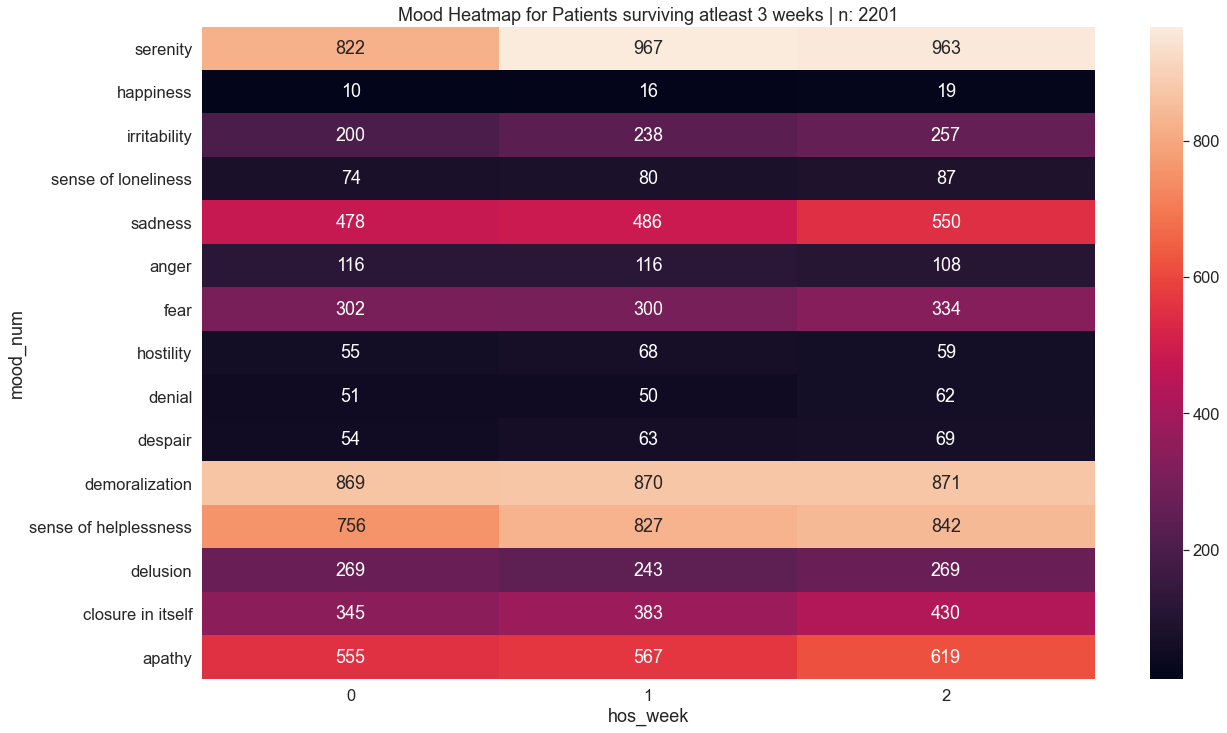

In [44]:
# general heatmaps
df_ms = df_mw[df_mw['survival_time_days'] >= 21]
df_ms = df_ms[df_ms['hos_week'] <= 2]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving atleast 3 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_3weeks.png', bbox_inches='tight')
plt.show()

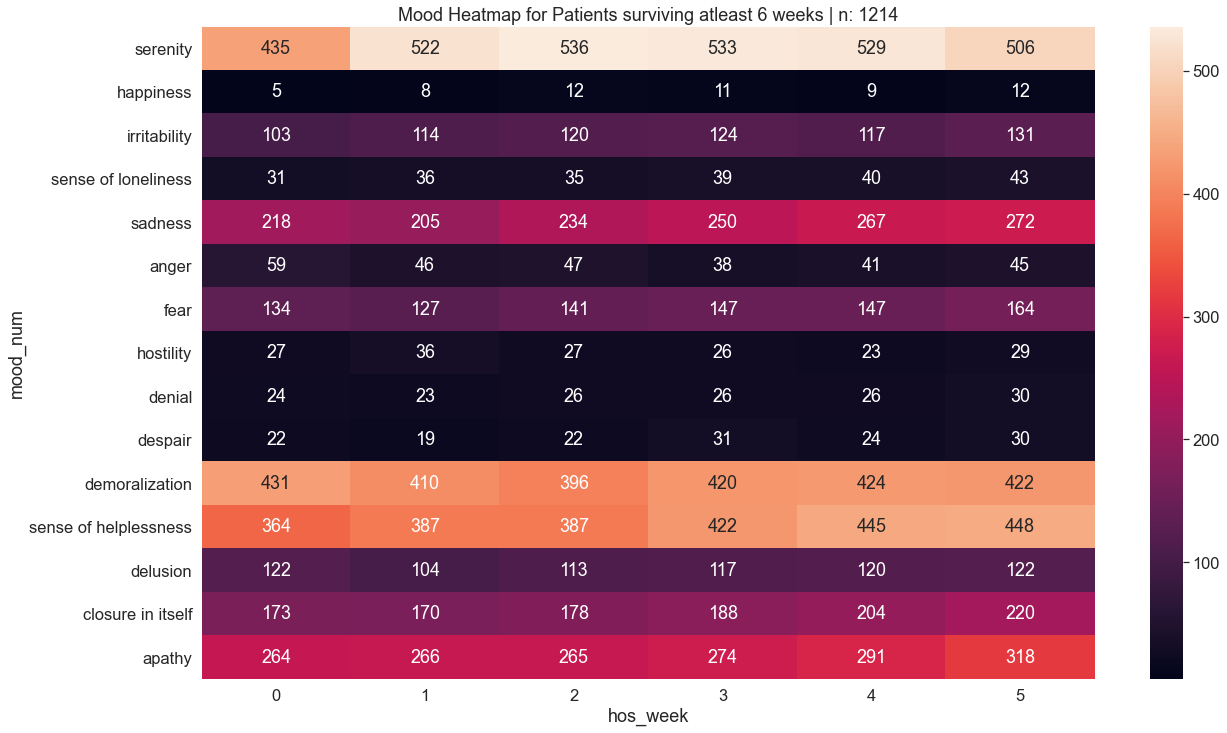

In [45]:
df_ms = df_mw[df_mw['survival_time_days'] >= 42]
df_ms = df_ms[df_ms['hos_week'] <= 5]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving atleast 6 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_6weeks.png', bbox_inches='tight')
plt.show()

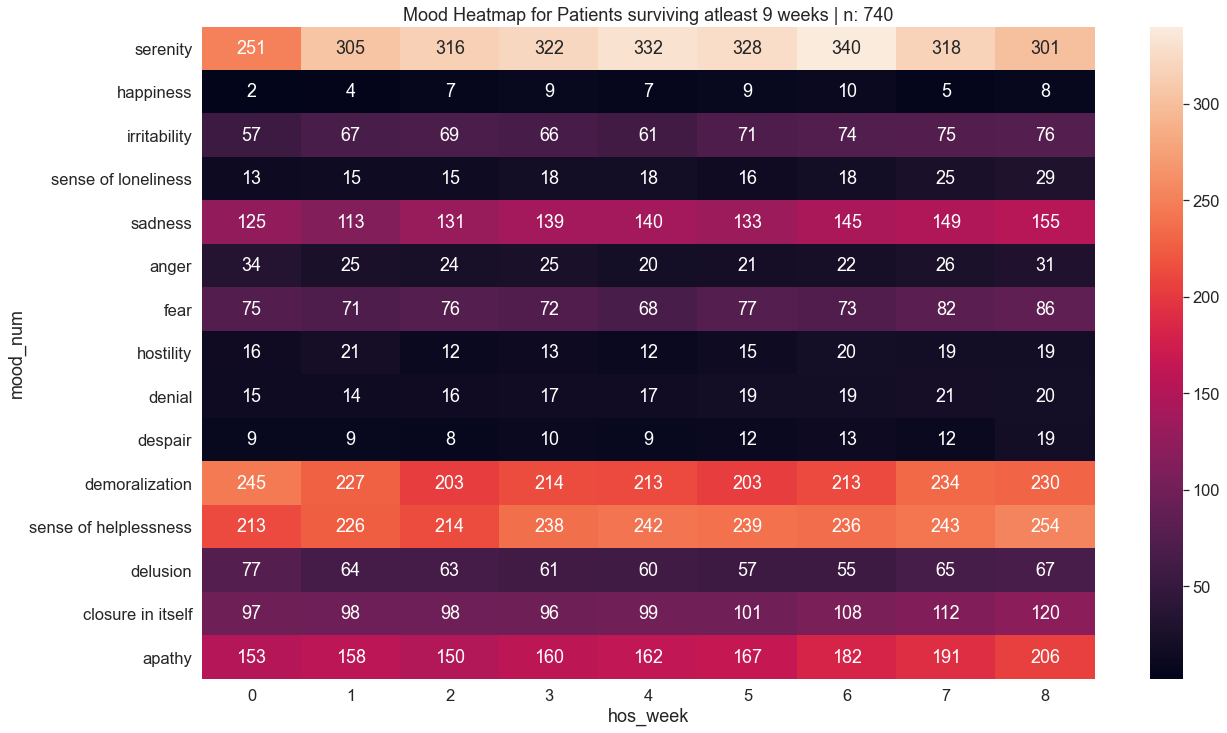

In [46]:
df_ms = df_mw[df_mw['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving atleast 9 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_9weeks.png', bbox_inches='tight')
plt.show()

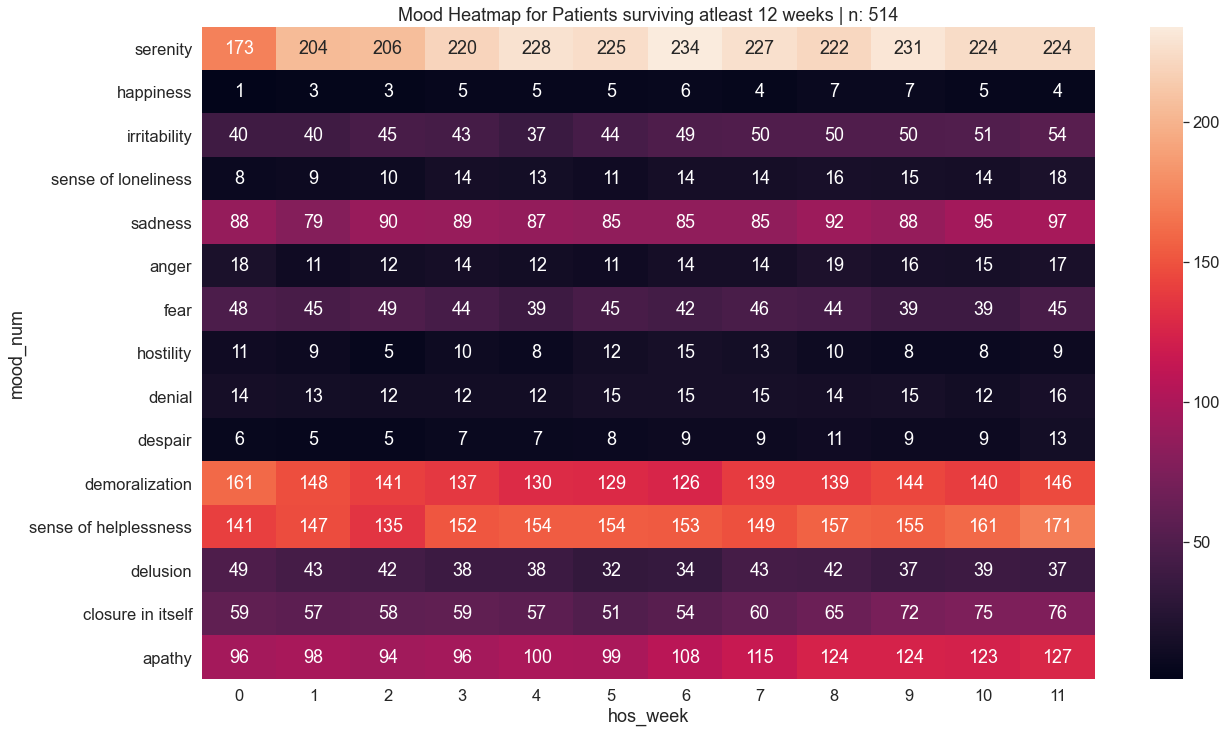

In [47]:
df_ms = df_mw[df_mw['survival_time_days'] >= 84]
df_ms = df_ms[df_ms['hos_week'] <= 11]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving atleast 12 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_12weeks.png', bbox_inches='tight')
plt.show()

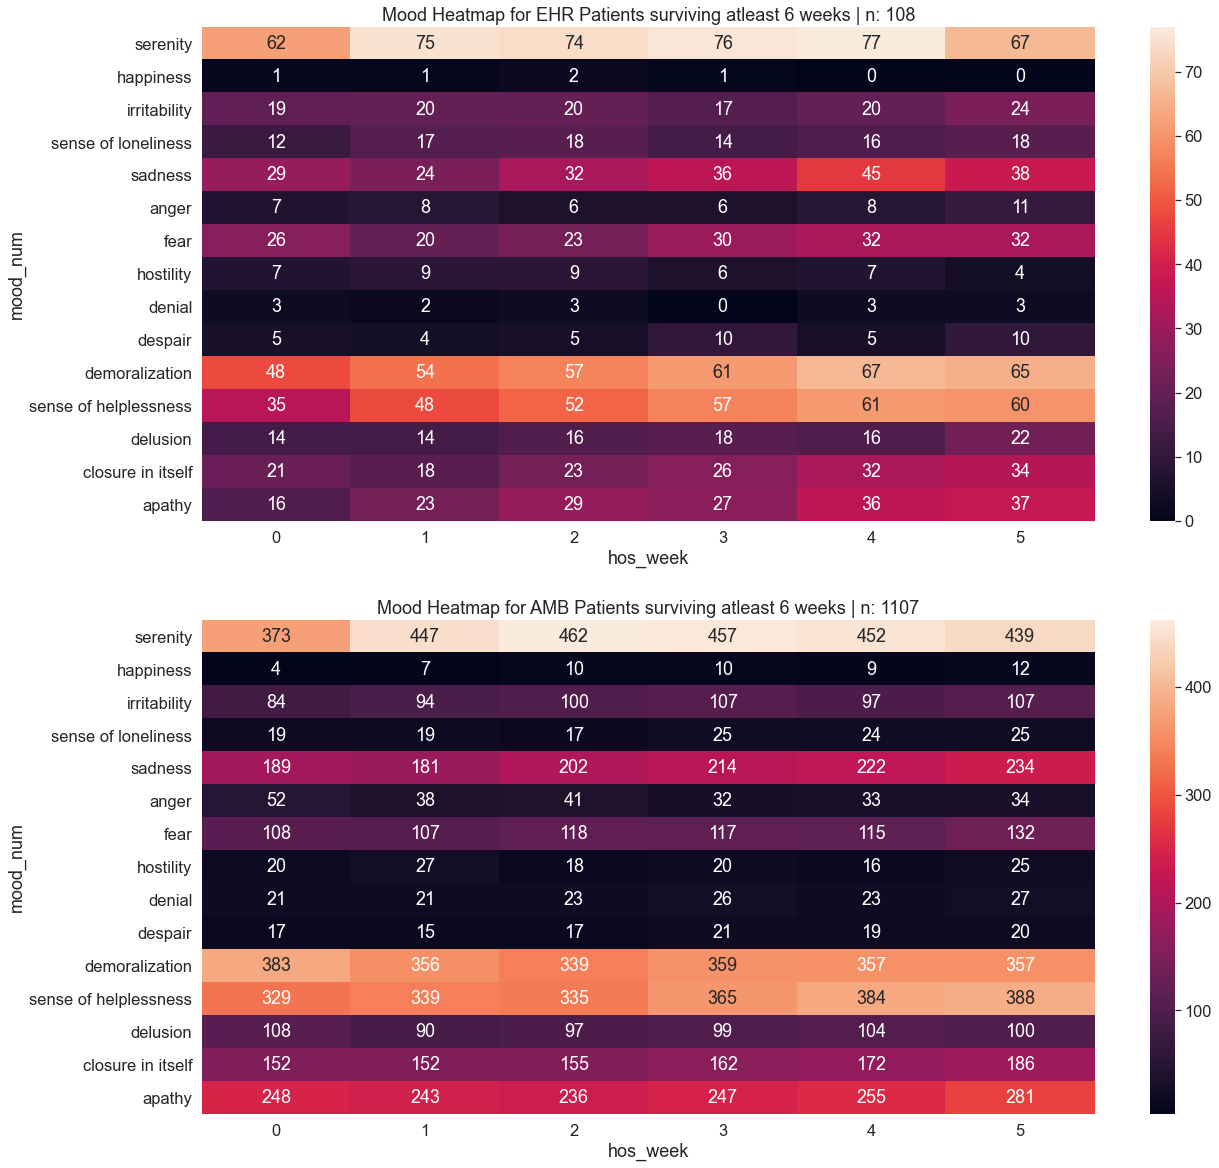

In [48]:
# heatmap of EHR vs AMB patients
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 42]
df_ms = df_ms[df_ms['hos_week'] <= 5]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving atleast 6 weeks | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving atleast 6 weeks | n: ' + str(n2))
plt.savefig('./graphs/mood/mood_ehrtype_6w.png', bbox_inches='tight')
plt.show()

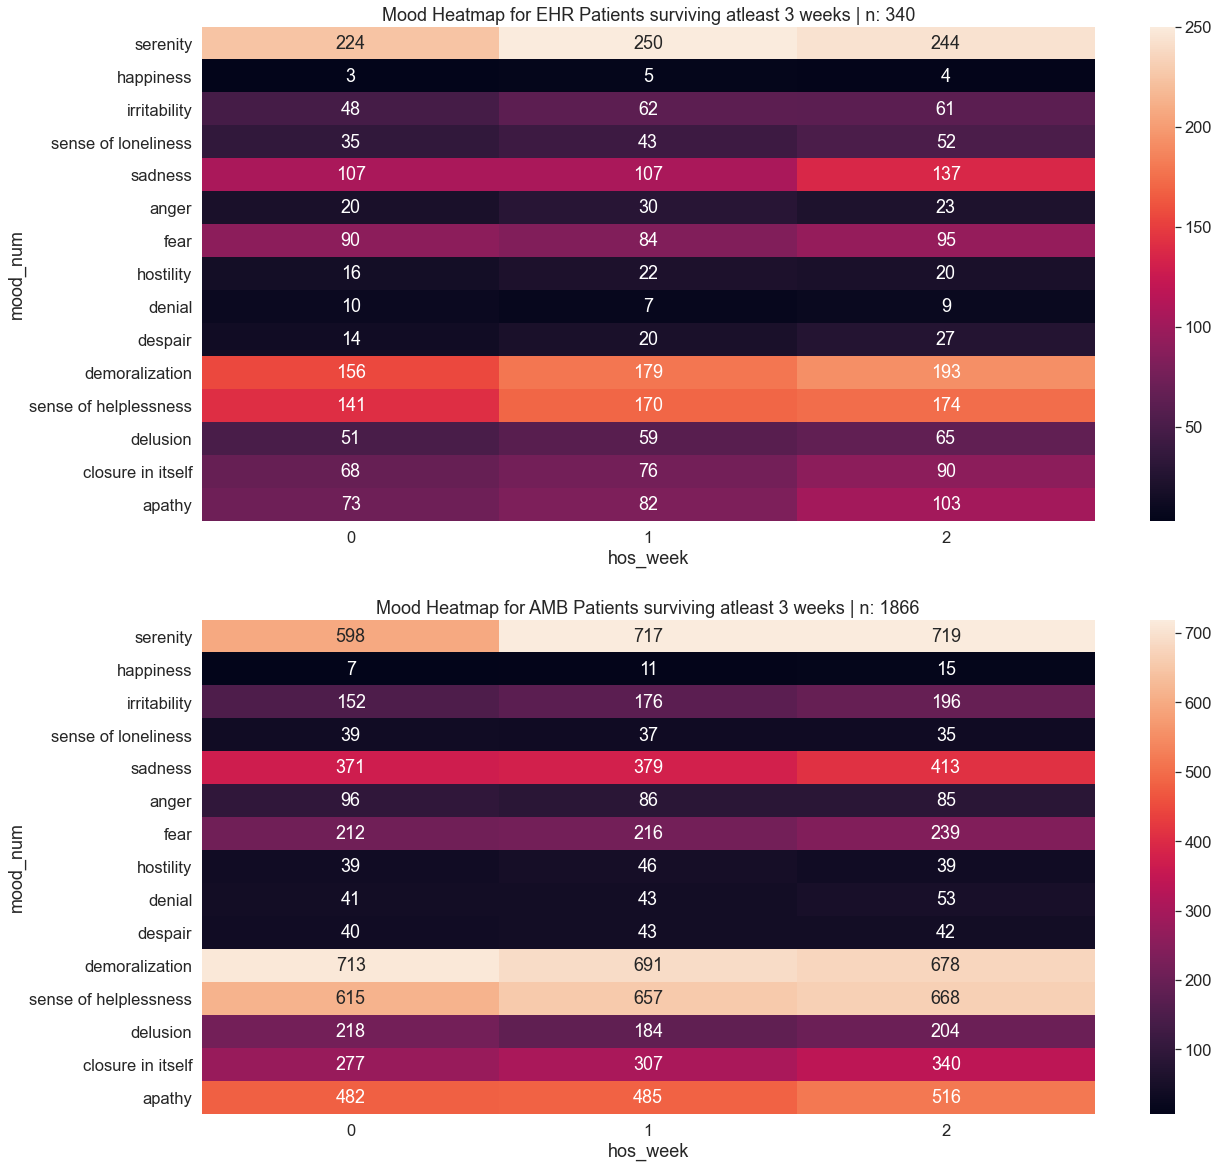

In [49]:
# heatmap of EHR vs AMB patients
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 21]
df_ms = df_ms[df_ms['hos_week'] <= 2]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving atleast 3 weeks | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving atleast 3 weeks | n: ' + str(n2))
plt.savefig('./graphs/mood/mood_ehrtype_3w.png', bbox_inches='tight')
plt.show()

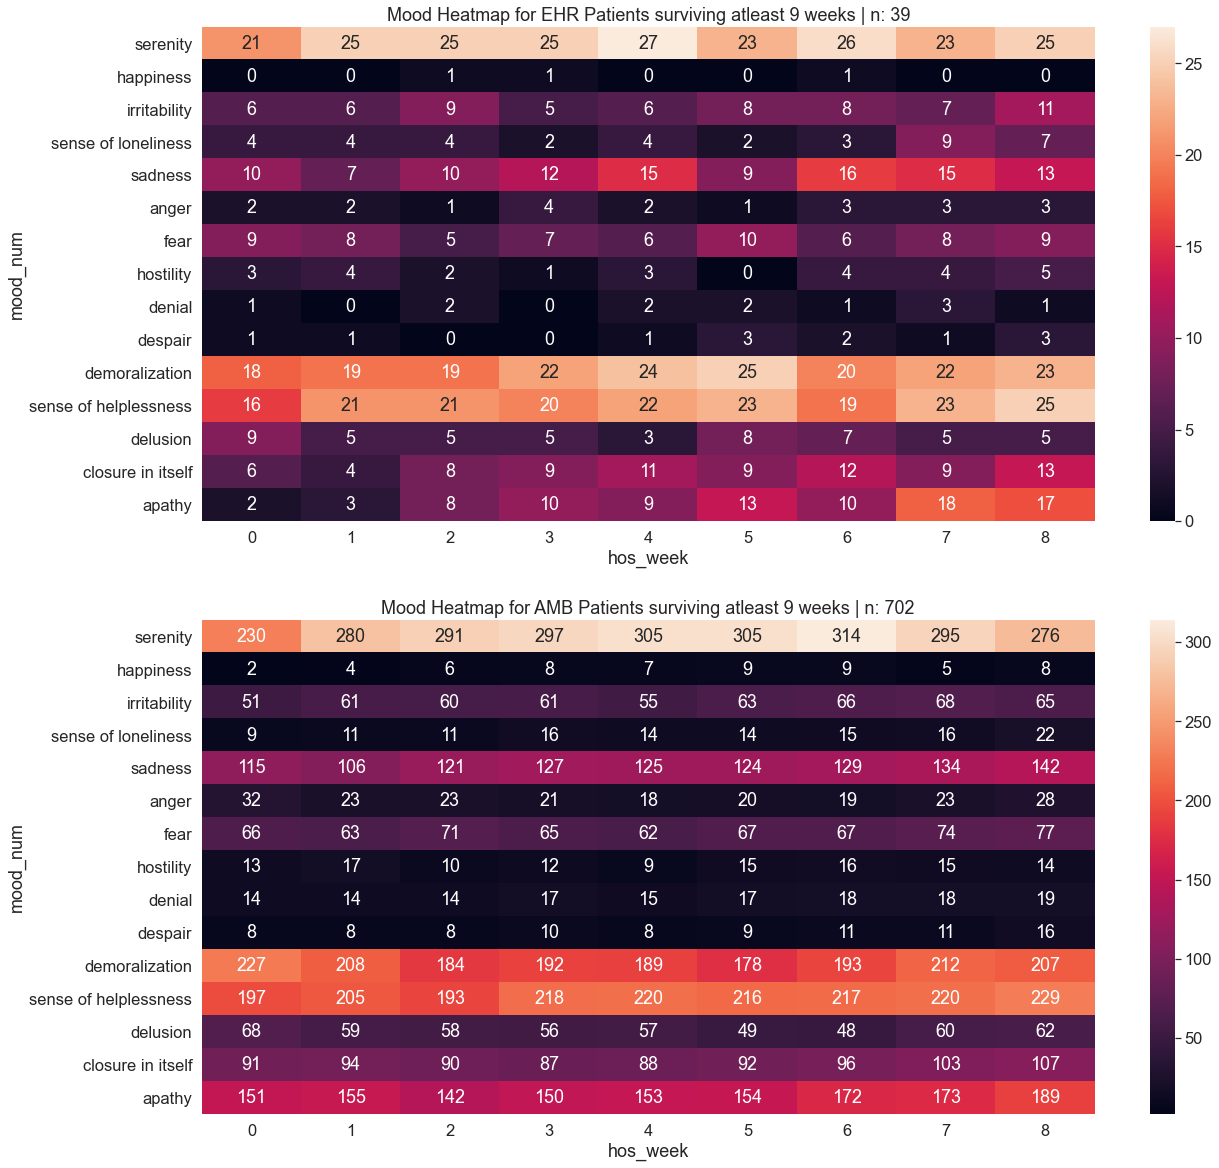

In [50]:
# heatmap of EHR vs AMB patients
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving atleast 9 weeks | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving atleast 9 weeks | n: ' + str(n2))
plt.savefig('./graphs/mood/mood_ehrtype_9w.png', bbox_inches='tight')
plt.show()

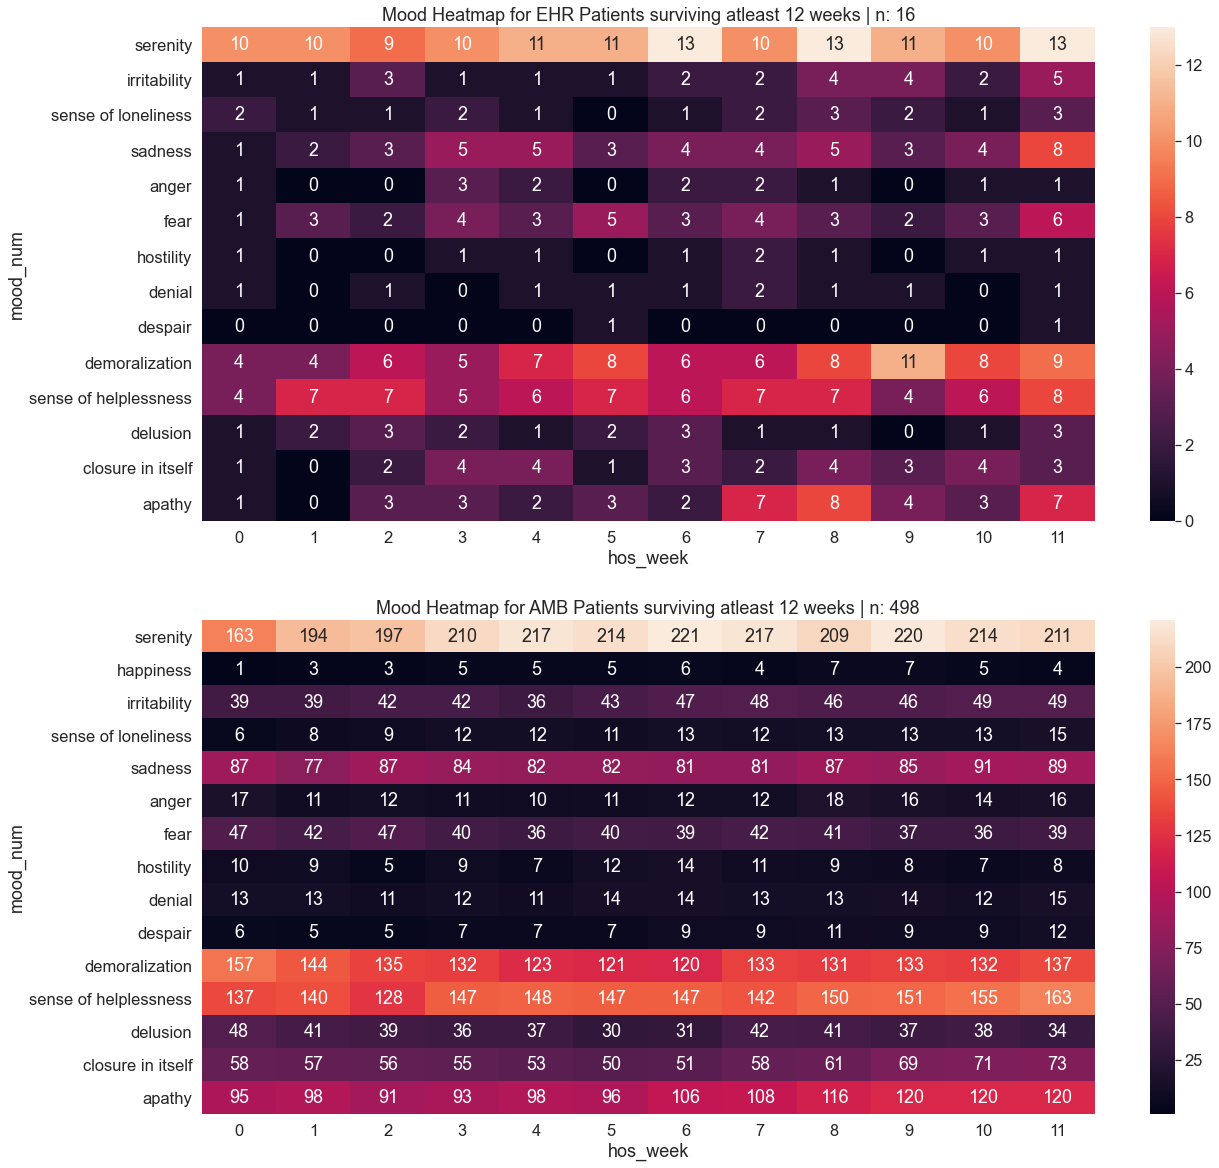

In [51]:
# heatmap of EHR vs AMB patients
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 84]
df_ms = df_ms[df_ms['hos_week'] <= 11]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
cats1 = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats1.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats1, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving atleast 12 weeks | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving atleast 12 weeks | n: ' + str(n2))
plt.savefig('./graphs/mood/mood_ehrtype_12w.png', bbox_inches='tight')
plt.show()

In [52]:
# skyline plot for EHRType


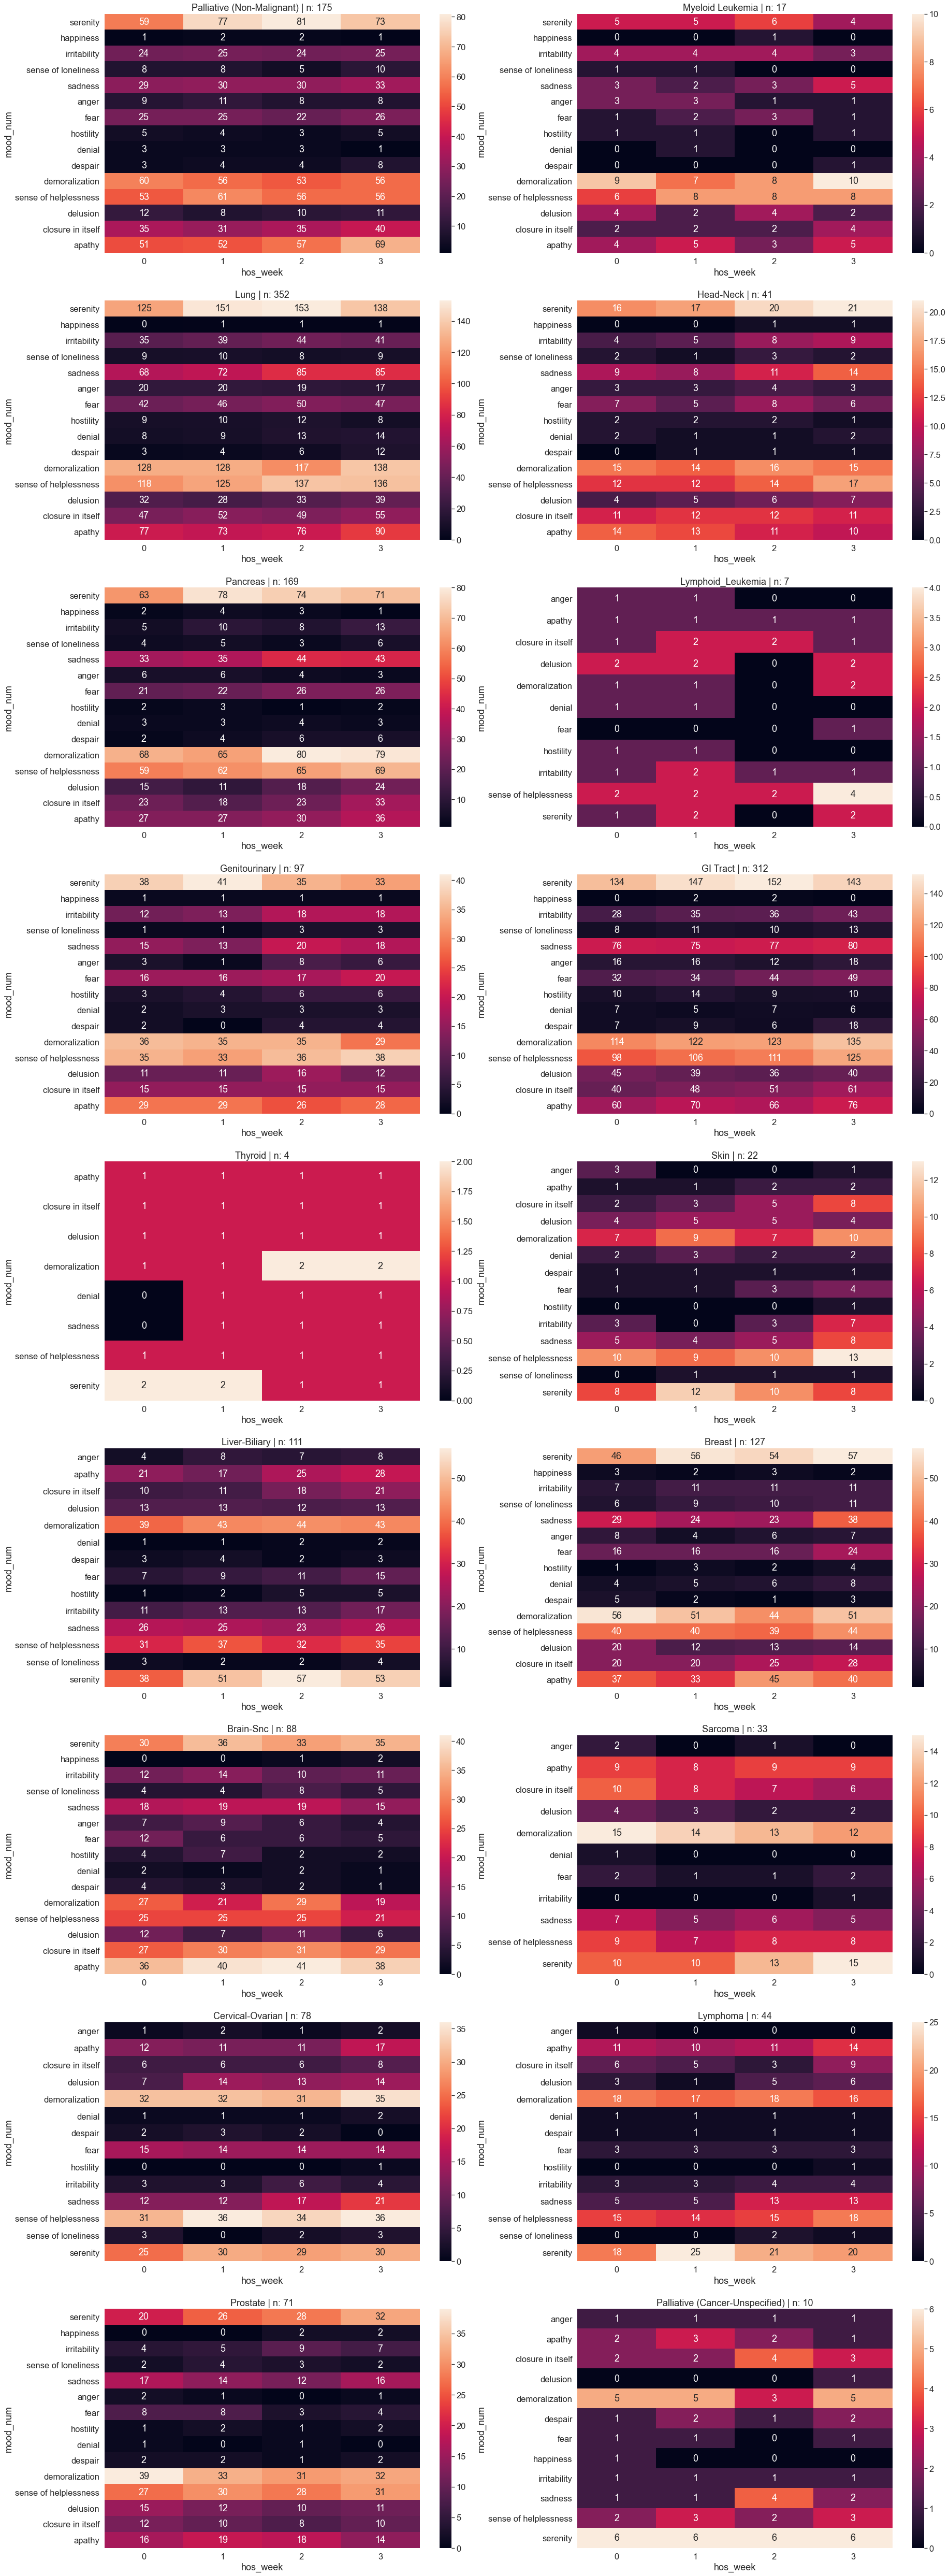

In [53]:
# heatmap for diagnosis type
plt.rcParams['figure.figsize'] = [30, 90]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18)) = plt.subplots(9, 2)
df_ms = df_mw[df_mw['survival_time_days'] >= 28]
df_ms = df_ms[df_ms['hos_week'] <= 3]
df1 = df_ms[df_ms['Diagnosis'] == 'Palliative (Non-Malignant)']
df2 = df_ms[df_ms['Diagnosis'] == 'Myeloid Leukemia']
df3 = df_ms[df_ms['Diagnosis'] == 'Lung']
df4 = df_ms[df_ms['Diagnosis'] == 'Head-Neck']
df5 = df_ms[df_ms['Diagnosis'] == 'Pancreas']
df6 = df_ms[df_ms['Diagnosis'] == 'Lymphoid_Leukemia']
df7 = df_ms[df_ms['Diagnosis'] == 'Genitourinary']
df8 = df_ms[df_ms['Diagnosis'] == 'GI Tract']
df9 = df_ms[df_ms['Diagnosis'] == 'Thyroid']
df10 = df_ms[df_ms['Diagnosis'] == 'Skin']
df11= df_ms[df_ms['Diagnosis'] == 'Liver-Biliary']
df12 = df_ms[df_ms['Diagnosis'] == 'Breast']
df13 = df_ms[df_ms['Diagnosis'] == 'Brain-Snc']
df14 = df_ms[df_ms['Diagnosis'] == 'Sarcoma']
df15 = df_ms[df_ms['Diagnosis'] == 'Cervical-Ovarian']
df16 = df_ms[df_ms['Diagnosis'] == 'Lymphoma']
df17 = df_ms[df_ms['Diagnosis'] == 'Prostate']
df18 = df_ms[df_ms['Diagnosis'] == 'Palliative (Cancer-Unspecified)']

n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
n3 = len(df3.IDEHR.unique())
n4 = len(df4.IDEHR.unique())
n5 = len(df5.IDEHR.unique())
n6 = len(df6.IDEHR.unique())
n7 = len(df7.IDEHR.unique())
n8 = len(df8.IDEHR.unique())
n9 = len(df9.IDEHR.unique())
n10 = len(df10.IDEHR.unique())
n11= len(df11.IDEHR.unique())
n12 = len(df12.IDEHR.unique())
n13 = len(df13.IDEHR.unique())
n14 = len(df14.IDEHR.unique())
n15 = len(df15.IDEHR.unique())
n16 = len(df16.IDEHR.unique())
n17 = len(df17.IDEHR.unique())
n18 = len(df18.IDEHR.unique())

df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df3 = df3[['mood_num', 'hos_week']].reset_index(drop=True)
df3 = df3.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df4 = df4[['mood_num', 'hos_week']].reset_index(drop=True)
df4 = df4.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df5 = df5[['mood_num', 'hos_week']].reset_index(drop=True)
df5 = df5.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df6 = df6[['mood_num', 'hos_week']].reset_index(drop=True)
df6 = df6.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df7 = df7[['mood_num', 'hos_week']].reset_index(drop=True)
df7 = df7.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df8 = df8[['mood_num', 'hos_week']].reset_index(drop=True)
df8 = df8.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df9 = df9[['mood_num', 'hos_week']].reset_index(drop=True)
df9 = df9.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df10 = df10[['mood_num', 'hos_week']].reset_index(drop=True)
df10 = df10.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df11 = df11[['mood_num', 'hos_week']].reset_index(drop=True)
df11 = df11.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df12 = df12[['mood_num', 'hos_week']].reset_index(drop=True)
df12 = df12.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df13 = df13[['mood_num', 'hos_week']].reset_index(drop=True)
df13 = df13.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df14 = df14[['mood_num', 'hos_week']].reset_index(drop=True)
df14 = df14.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df15 = df15[['mood_num', 'hos_week']].reset_index(drop=True)
df15 = df15.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df16 = df16[['mood_num', 'hos_week']].reset_index(drop=True)
df16 = df16.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df17 = df17[['mood_num', 'hos_week']].reset_index(drop=True)
df17 = df17.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df18 = df18[['mood_num', 'hos_week']].reset_index(drop=True)
df18 = df18.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()

cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df3['mood_num'] = pd.Categorical(df3['mood_num'], categories=cats, ordered=True)
df4['mood_num'] = pd.Categorical(df4['mood_num'], categories=cats, ordered=True)
df5['mood_num'] = pd.Categorical(df5['mood_num'], categories=cats, ordered=True)
df6['mood_num'] = pd.Categorical(df6['mood_num'], categories=cats, ordered=True)
df7['mood_num'] = pd.Categorical(df7['mood_num'], categories=cats, ordered=True)
df8['mood_num'] = pd.Categorical(df8['mood_num'], categories=cats, ordered=True)
df9['mood_num'] = pd.Categorical(df9['mood_num'], categories=cats, ordered=True)
df10['mood_num'] = pd.Categorical(df10['mood_num'], categories=cats, ordered=True)
df11['mood_num'] = pd.Categorical(df11['mood_num'], categories=cats, ordered=True)
df12['mood_num'] = pd.Categorical(df12['mood_num'], categories=cats, ordered=True)
df13['mood_num'] = pd.Categorical(df13['mood_num'], categories=cats, ordered=True)
df14['mood_num'] = pd.Categorical(df14['mood_num'], categories=cats, ordered=True)
df15['mood_num'] = pd.Categorical(df15['mood_num'], categories=cats, ordered=True)
df16['mood_num'] = pd.Categorical(df16['mood_num'], categories=cats, ordered=True)
df17['mood_num'] = pd.Categorical(df17['mood_num'], categories=cats, ordered=True)
df18['mood_num'] = pd.Categorical(df18['mood_num'], categories=cats, ordered=True)

df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df3 = df3.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df4 = df4.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df5 = df5.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df6 = df6.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df7 = df7.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df8 = df8.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df9 = df9.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df10 = df10.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df11 = df11.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df12 = df12.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df13 = df13.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df14 = df14.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df15 = df15.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df16 = df16.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df17 = df17.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df18 = df18.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)

sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Palliative (Non-Malignant) | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Myeloid Leukemia | n: ' + str(n2))
sns.heatmap(df3, annot=True, fmt='g', ax=ax3)
ax3.set_facecolor('xkcd:black')
ax3.set_title('Lung | n: ' + str(n3))
sns.heatmap(df4, annot=True, fmt='g', ax=ax4)
ax4.set_facecolor('xkcd:black')
ax4.set_title('Head-Neck | n: ' + str(n4))
sns.heatmap(df5, annot=True, fmt='g', ax=ax5)
ax5.set_facecolor('xkcd:black')
ax5.set_title('Pancreas | n: ' + str(n5))
sns.heatmap(df6, annot=True, fmt='g', ax=ax6)
ax6.set_facecolor('xkcd:black')
ax6.set_title('Lymphoid_Leukemia | n: ' + str(n6))
sns.heatmap(df7, annot=True, fmt='g', ax=ax7)
ax7.set_facecolor('xkcd:black')
ax7.set_title('Genitourinary | n: ' + str(n7))
sns.heatmap(df8, annot=True, fmt='g', ax=ax8)
ax8.set_facecolor('xkcd:black')
ax8.set_title('GI Tract | n: ' + str(n8))
sns.heatmap(df9, annot=True, fmt='g', ax=ax9)
ax9.set_facecolor('xkcd:black')
ax9.set_title('Thyroid | n: ' + str(n9))
sns.heatmap(df10, annot=True, fmt='g', ax=ax10)
ax10.set_facecolor('xkcd:black')
ax10.set_title('Skin | n: ' + str(n10))
sns.heatmap(df11, annot=True, fmt='g', ax=ax11)
ax11.set_facecolor('xkcd:black')
ax11.set_title('Liver-Biliary | n: ' + str(n11))
sns.heatmap(df12, annot=True, fmt='g', ax=ax12)
ax12.set_facecolor('xkcd:black')
ax12.set_title('Breast | n: ' + str(n12))
sns.heatmap(df13, annot=True, fmt='g', ax=ax13)
ax13.set_facecolor('xkcd:black')
ax13.set_title('Brain-Snc | n: ' + str(n13))
sns.heatmap(df14, annot=True, fmt='g', ax=ax14)
ax14.set_facecolor('xkcd:black')
ax14.set_title('Sarcoma | n: ' + str(n14))
sns.heatmap(df15, annot=True, fmt='g', ax=ax15)
ax15.set_facecolor('xkcd:black')
ax15.set_title('Cervical-Ovarian | n: ' + str(n15))
sns.heatmap(df16, annot=True, fmt='g', ax=ax16)
ax16.set_facecolor('xkcd:black')
ax16.set_title('Lymphoma | n: ' + str(n16))
sns.heatmap(df17, annot=True, fmt='g', ax=ax17)
ax17.set_facecolor('xkcd:black')
ax17.set_title('Prostate | n: ' + str(n17))
sns.heatmap(df18, annot=True, fmt='g', ax=ax18)
ax18.set_facecolor('xkcd:black')
ax18.set_title('Palliative (Cancer-Unspecified) | n: ' + str(n18))

# fig.suptitle('Mood Heatmap for Patients surviving atleast 6 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_heatmaps_by_diag.png', bbox_inches='tight')
plt.show()

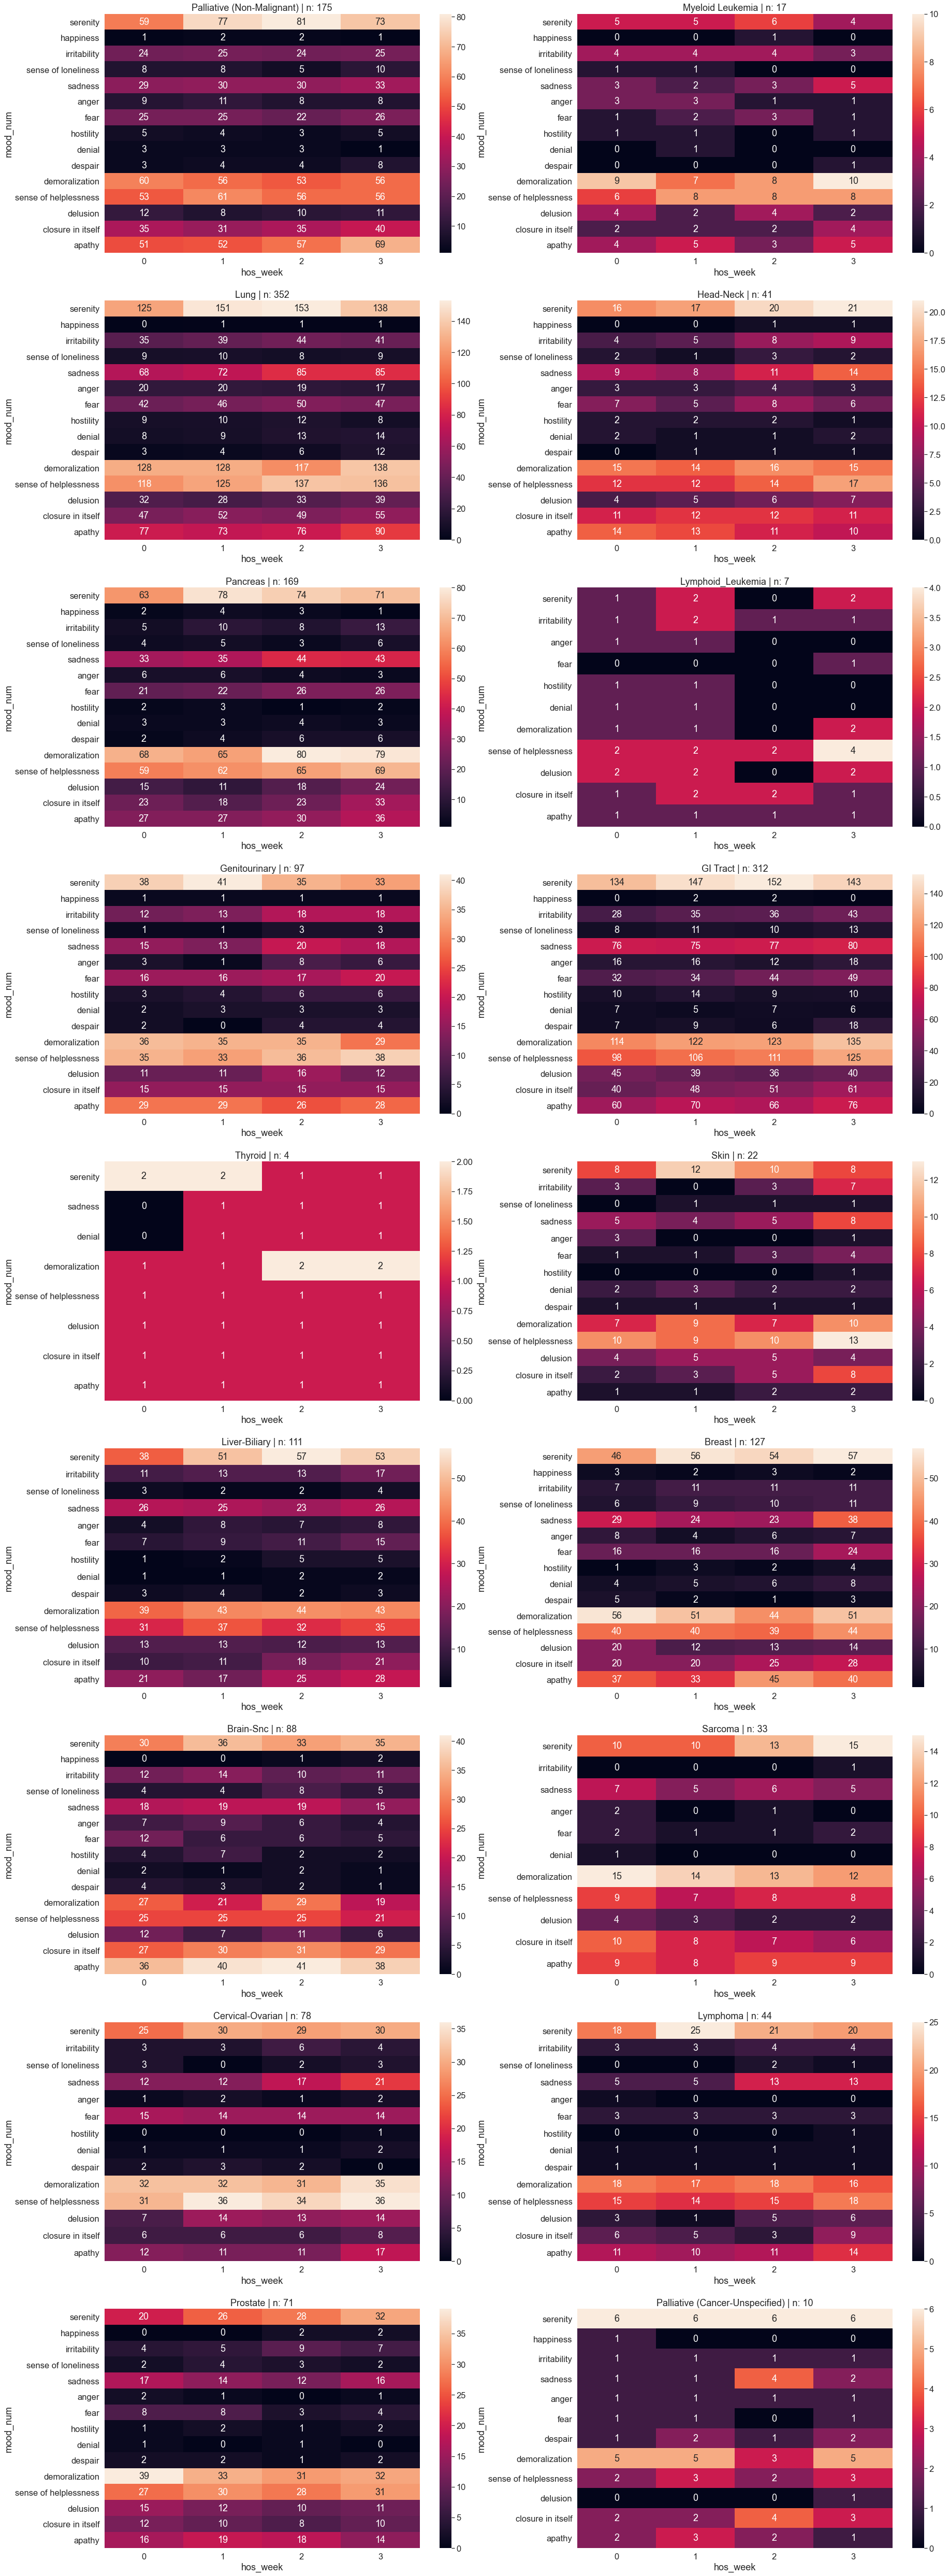

In [54]:
# heatmap for diagnosis type with uniform yticks
plt.rcParams['figure.figsize'] = [30, 90]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18)) = plt.subplots(9, 2)
df_ms = df_mw[df_mw['survival_time_days'] >= 28]
df_ms = df_ms[df_ms['hos_week'] <= 3]
df1 = df_ms[df_ms['Diagnosis'] == 'Palliative (Non-Malignant)']
df2 = df_ms[df_ms['Diagnosis'] == 'Myeloid Leukemia']
df3 = df_ms[df_ms['Diagnosis'] == 'Lung']
df4 = df_ms[df_ms['Diagnosis'] == 'Head-Neck']
df5 = df_ms[df_ms['Diagnosis'] == 'Pancreas']
df6 = df_ms[df_ms['Diagnosis'] == 'Lymphoid_Leukemia']
df7 = df_ms[df_ms['Diagnosis'] == 'Genitourinary']
df8 = df_ms[df_ms['Diagnosis'] == 'GI Tract']
df9 = df_ms[df_ms['Diagnosis'] == 'Thyroid']
df10 = df_ms[df_ms['Diagnosis'] == 'Skin']
df11= df_ms[df_ms['Diagnosis'] == 'Liver-Biliary']
df12 = df_ms[df_ms['Diagnosis'] == 'Breast']
df13 = df_ms[df_ms['Diagnosis'] == 'Brain-Snc']
df14 = df_ms[df_ms['Diagnosis'] == 'Sarcoma']
df15 = df_ms[df_ms['Diagnosis'] == 'Cervical-Ovarian']
df16 = df_ms[df_ms['Diagnosis'] == 'Lymphoma']
df17 = df_ms[df_ms['Diagnosis'] == 'Prostate']
df18 = df_ms[df_ms['Diagnosis'] == 'Palliative (Cancer-Unspecified)']

n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
n3 = len(df3.IDEHR.unique())
n4 = len(df4.IDEHR.unique())
n5 = len(df5.IDEHR.unique())
n6 = len(df6.IDEHR.unique())
n7 = len(df7.IDEHR.unique())
n8 = len(df8.IDEHR.unique())
n9 = len(df9.IDEHR.unique())
n10 = len(df10.IDEHR.unique())
n11= len(df11.IDEHR.unique())
n12 = len(df12.IDEHR.unique())
n13 = len(df13.IDEHR.unique())
n14 = len(df14.IDEHR.unique())
n15 = len(df15.IDEHR.unique())
n16 = len(df16.IDEHR.unique())
n17 = len(df17.IDEHR.unique())
n18 = len(df18.IDEHR.unique())

df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df3 = df3[['mood_num', 'hos_week']].reset_index(drop=True)
df3 = df3.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df4 = df4[['mood_num', 'hos_week']].reset_index(drop=True)
df4 = df4.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df5 = df5[['mood_num', 'hos_week']].reset_index(drop=True)
df5 = df5.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df6 = df6[['mood_num', 'hos_week']].reset_index(drop=True)
df6 = df6.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df7 = df7[['mood_num', 'hos_week']].reset_index(drop=True)
df7 = df7.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df8 = df8[['mood_num', 'hos_week']].reset_index(drop=True)
df8 = df8.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df9 = df9[['mood_num', 'hos_week']].reset_index(drop=True)
df9 = df9.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df10 = df10[['mood_num', 'hos_week']].reset_index(drop=True)
df10 = df10.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df11 = df11[['mood_num', 'hos_week']].reset_index(drop=True)
df11 = df11.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df12 = df12[['mood_num', 'hos_week']].reset_index(drop=True)
df12 = df12.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df13 = df13[['mood_num', 'hos_week']].reset_index(drop=True)
df13 = df13.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df14 = df14[['mood_num', 'hos_week']].reset_index(drop=True)
df14 = df14.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df15 = df15[['mood_num', 'hos_week']].reset_index(drop=True)
df15 = df15.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df16 = df16[['mood_num', 'hos_week']].reset_index(drop=True)
df16 = df16.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df17 = df17[['mood_num', 'hos_week']].reset_index(drop=True)
df17 = df17.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df18 = df18[['mood_num', 'hos_week']].reset_index(drop=True)
df18 = df18.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()

cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
cats_ll = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'hostility', 'fear', 'anger', 'irritability', 'serenity']
cats_ll.reverse()
cats_thy = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'sadness', 'serenity']
cats_thy.reverse()
cats_skin = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_skin.reverse()
cats_lb = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_lb.reverse()
cats_sc = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'fear', 'anger', 'sadness', 'irritability', 'serenity']
cats_sc.reverse()
cats_cov = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_cov.reverse()
cats_lym = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_lym.reverse()
cats_pcu = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'fear', 'anger', 'sadness', 'irritability', 'happiness', 'serenity']
cats_pcu.reverse()

df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df3['mood_num'] = pd.Categorical(df3['mood_num'], categories=cats, ordered=True)
df4['mood_num'] = pd.Categorical(df4['mood_num'], categories=cats, ordered=True)
df5['mood_num'] = pd.Categorical(df5['mood_num'], categories=cats, ordered=True)
df6['mood_num'] = pd.Categorical(df6['mood_num'], categories=cats_ll, ordered=True)
df7['mood_num'] = pd.Categorical(df7['mood_num'], categories=cats, ordered=True)
df8['mood_num'] = pd.Categorical(df8['mood_num'], categories=cats, ordered=True)
df9['mood_num'] = pd.Categorical(df9['mood_num'], categories=cats_thy, ordered=True)
df10['mood_num'] = pd.Categorical(df10['mood_num'], categories=cats_skin, ordered=True)
df11['mood_num'] = pd.Categorical(df11['mood_num'], categories=cats_lb, ordered=True)
df12['mood_num'] = pd.Categorical(df12['mood_num'], categories=cats, ordered=True)
df13['mood_num'] = pd.Categorical(df13['mood_num'], categories=cats, ordered=True)
df14['mood_num'] = pd.Categorical(df14['mood_num'], categories=cats_sc, ordered=True)
df15['mood_num'] = pd.Categorical(df15['mood_num'], categories=cats_cov, ordered=True)
df16['mood_num'] = pd.Categorical(df16['mood_num'], categories=cats_lym, ordered=True)
df17['mood_num'] = pd.Categorical(df17['mood_num'], categories=cats, ordered=True)
df18['mood_num'] = pd.Categorical(df18['mood_num'], categories=cats_pcu, ordered=True)

df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df3 = df3.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df4 = df4.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df5 = df5.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df6 = df6.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df7 = df7.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df8 = df8.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df9 = df9.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df10 = df10.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df11 = df11.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df12 = df12.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df13 = df13.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df14 = df14.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df15 = df15.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df16 = df16.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df17 = df17.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df18 = df18.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)

sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Palliative (Non-Malignant) | n: ' + str(n1))
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Myeloid Leukemia | n: ' + str(n2))
sns.heatmap(df3, annot=True, fmt='g', ax=ax3)
ax3.set_facecolor('xkcd:black')
ax3.set_title('Lung | n: ' + str(n3))
sns.heatmap(df4, annot=True, fmt='g', ax=ax4)
ax4.set_facecolor('xkcd:black')
ax4.set_title('Head-Neck | n: ' + str(n4))
sns.heatmap(df5, annot=True, fmt='g', ax=ax5)
ax5.set_facecolor('xkcd:black')
ax5.set_title('Pancreas | n: ' + str(n5))
sns.heatmap(df6, annot=True, fmt='g', ax=ax6)
ax6.set_facecolor('xkcd:black')
ax6.set_title('Lymphoid_Leukemia | n: ' + str(n6))
sns.heatmap(df7, annot=True, fmt='g', ax=ax7)
ax7.set_facecolor('xkcd:black')
ax7.set_title('Genitourinary | n: ' + str(n7))
sns.heatmap(df8, annot=True, fmt='g', ax=ax8)
ax8.set_facecolor('xkcd:black')
ax8.set_title('GI Tract | n: ' + str(n8))
sns.heatmap(df9, annot=True, fmt='g', ax=ax9)
ax9.set_facecolor('xkcd:black')
ax9.set_title('Thyroid | n: ' + str(n9))
sns.heatmap(df10, annot=True, fmt='g', ax=ax10)
ax10.set_facecolor('xkcd:black')
ax10.set_title('Skin | n: ' + str(n10))
sns.heatmap(df11, annot=True, fmt='g', ax=ax11)
ax11.set_facecolor('xkcd:black')
ax11.set_title('Liver-Biliary | n: ' + str(n11))
sns.heatmap(df12, annot=True, fmt='g', ax=ax12)
ax12.set_facecolor('xkcd:black')
ax12.set_title('Breast | n: ' + str(n12))
sns.heatmap(df13, annot=True, fmt='g', ax=ax13)
ax13.set_facecolor('xkcd:black')
ax13.set_title('Brain-Snc | n: ' + str(n13))
sns.heatmap(df14, annot=True, fmt='g', ax=ax14)
ax14.set_facecolor('xkcd:black')
ax14.set_title('Sarcoma | n: ' + str(n14))
sns.heatmap(df15, annot=True, fmt='g', ax=ax15)
ax15.set_facecolor('xkcd:black')
ax15.set_title('Cervical-Ovarian | n: ' + str(n15))
sns.heatmap(df16, annot=True, fmt='g', ax=ax16)
ax16.set_facecolor('xkcd:black')
ax16.set_title('Lymphoma | n: ' + str(n16))
sns.heatmap(df17, annot=True, fmt='g', ax=ax17)
ax17.set_facecolor('xkcd:black')
ax17.set_title('Prostate | n: ' + str(n17))
sns.heatmap(df18, annot=True, fmt='g', ax=ax18)
ax18.set_facecolor('xkcd:black')
ax18.set_title('Palliative (Cancer-Unspecified) | n: ' + str(n18))

# fig.suptitle('Mood Heatmap for Patients surviving atleast 6 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_heatmaps_by_diag_2.png', bbox_inches='tight')
plt.show()

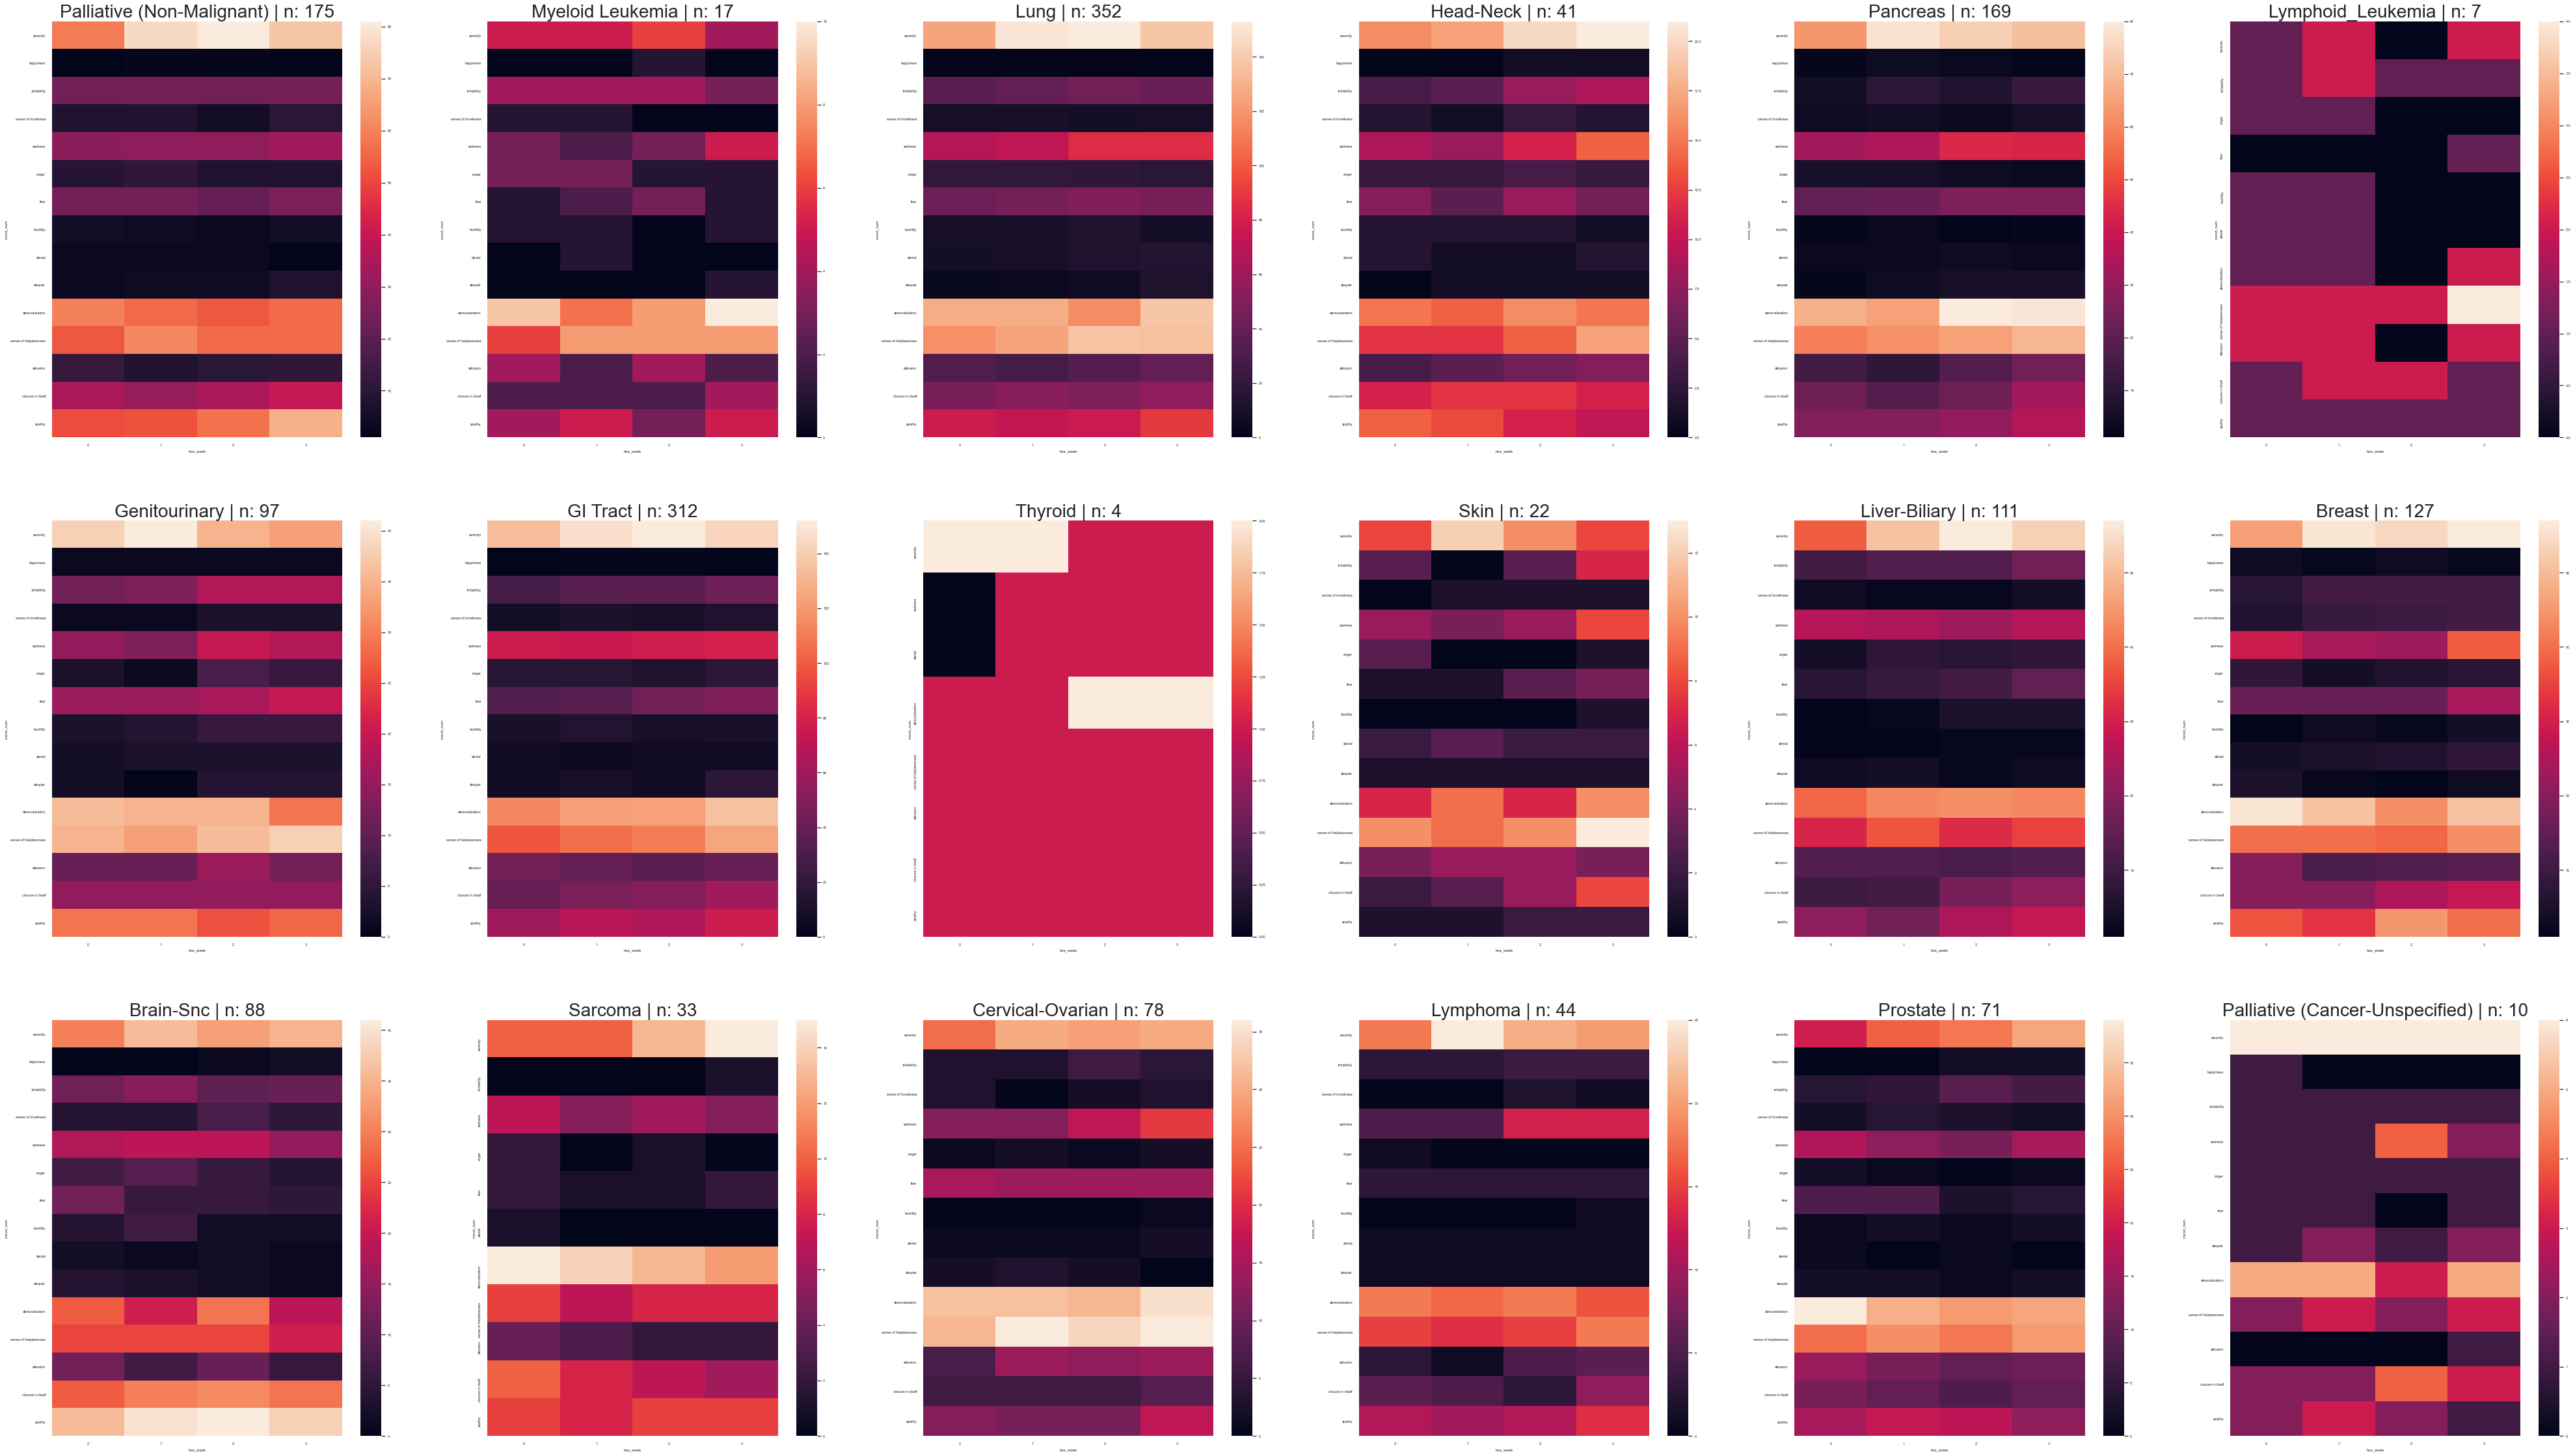

In [55]:
# heatmap for diagnosis type with uniform yticks with small fig size
plt.rcParams['figure.figsize'] = [70, 40]
sns.set(font_scale=0.5)
fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18)) = plt.subplots(3, 6)
df_ms = df_mw[df_mw['survival_time_days'] >= 28]
df_ms = df_ms[df_ms['hos_week'] <= 3]
df1 = df_ms[df_ms['Diagnosis'] == 'Palliative (Non-Malignant)']
df2 = df_ms[df_ms['Diagnosis'] == 'Myeloid Leukemia']
df3 = df_ms[df_ms['Diagnosis'] == 'Lung']
df4 = df_ms[df_ms['Diagnosis'] == 'Head-Neck']
df5 = df_ms[df_ms['Diagnosis'] == 'Pancreas']
df6 = df_ms[df_ms['Diagnosis'] == 'Lymphoid_Leukemia']
df7 = df_ms[df_ms['Diagnosis'] == 'Genitourinary']
df8 = df_ms[df_ms['Diagnosis'] == 'GI Tract']
df9 = df_ms[df_ms['Diagnosis'] == 'Thyroid']
df10 = df_ms[df_ms['Diagnosis'] == 'Skin']
df11= df_ms[df_ms['Diagnosis'] == 'Liver-Biliary']
df12 = df_ms[df_ms['Diagnosis'] == 'Breast']
df13 = df_ms[df_ms['Diagnosis'] == 'Brain-Snc']
df14 = df_ms[df_ms['Diagnosis'] == 'Sarcoma']
df15 = df_ms[df_ms['Diagnosis'] == 'Cervical-Ovarian']
df16 = df_ms[df_ms['Diagnosis'] == 'Lymphoma']
df17 = df_ms[df_ms['Diagnosis'] == 'Prostate']
df18 = df_ms[df_ms['Diagnosis'] == 'Palliative (Cancer-Unspecified)']

n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
n3 = len(df3.IDEHR.unique())
n4 = len(df4.IDEHR.unique())
n5 = len(df5.IDEHR.unique())
n6 = len(df6.IDEHR.unique())
n7 = len(df7.IDEHR.unique())
n8 = len(df8.IDEHR.unique())
n9 = len(df9.IDEHR.unique())
n10 = len(df10.IDEHR.unique())
n11= len(df11.IDEHR.unique())
n12 = len(df12.IDEHR.unique())
n13 = len(df13.IDEHR.unique())
n14 = len(df14.IDEHR.unique())
n15 = len(df15.IDEHR.unique())
n16 = len(df16.IDEHR.unique())
n17 = len(df17.IDEHR.unique())
n18 = len(df18.IDEHR.unique())

df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df3 = df3[['mood_num', 'hos_week']].reset_index(drop=True)
df3 = df3.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df4 = df4[['mood_num', 'hos_week']].reset_index(drop=True)
df4 = df4.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df5 = df5[['mood_num', 'hos_week']].reset_index(drop=True)
df5 = df5.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df6 = df6[['mood_num', 'hos_week']].reset_index(drop=True)
df6 = df6.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df7 = df7[['mood_num', 'hos_week']].reset_index(drop=True)
df7 = df7.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df8 = df8[['mood_num', 'hos_week']].reset_index(drop=True)
df8 = df8.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df9 = df9[['mood_num', 'hos_week']].reset_index(drop=True)
df9 = df9.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df10 = df10[['mood_num', 'hos_week']].reset_index(drop=True)
df10 = df10.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df11 = df11[['mood_num', 'hos_week']].reset_index(drop=True)
df11 = df11.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df12 = df12[['mood_num', 'hos_week']].reset_index(drop=True)
df12 = df12.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df13 = df13[['mood_num', 'hos_week']].reset_index(drop=True)
df13 = df13.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df14 = df14[['mood_num', 'hos_week']].reset_index(drop=True)
df14 = df14.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df15 = df15[['mood_num', 'hos_week']].reset_index(drop=True)
df15 = df15.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df16 = df16[['mood_num', 'hos_week']].reset_index(drop=True)
df16 = df16.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df17 = df17[['mood_num', 'hos_week']].reset_index(drop=True)
df17 = df17.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df18 = df18[['mood_num', 'hos_week']].reset_index(drop=True)
df18 = df18.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()

cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
cats_ll = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'hostility', 'fear', 'anger', 'irritability', 'serenity']
cats_ll.reverse()
cats_thy = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'sadness', 'serenity']
cats_thy.reverse()
cats_skin = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_skin.reverse()
cats_lb = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_lb.reverse()
cats_sc = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'denial', 'fear', 'anger', 'sadness', 'irritability', 'serenity']
cats_sc.reverse()
cats_cov = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_cov.reverse()
cats_lym = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats_lym.reverse()
cats_pcu = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'fear', 'anger', 'sadness', 'irritability', 'happiness', 'serenity']
cats_pcu.reverse()

df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df3['mood_num'] = pd.Categorical(df3['mood_num'], categories=cats, ordered=True)
df4['mood_num'] = pd.Categorical(df4['mood_num'], categories=cats, ordered=True)
df5['mood_num'] = pd.Categorical(df5['mood_num'], categories=cats, ordered=True)
df6['mood_num'] = pd.Categorical(df6['mood_num'], categories=cats_ll, ordered=True)
df7['mood_num'] = pd.Categorical(df7['mood_num'], categories=cats, ordered=True)
df8['mood_num'] = pd.Categorical(df8['mood_num'], categories=cats, ordered=True)
df9['mood_num'] = pd.Categorical(df9['mood_num'], categories=cats_thy, ordered=True)
df10['mood_num'] = pd.Categorical(df10['mood_num'], categories=cats_skin, ordered=True)
df11['mood_num'] = pd.Categorical(df11['mood_num'], categories=cats_lb, ordered=True)
df12['mood_num'] = pd.Categorical(df12['mood_num'], categories=cats, ordered=True)
df13['mood_num'] = pd.Categorical(df13['mood_num'], categories=cats, ordered=True)
df14['mood_num'] = pd.Categorical(df14['mood_num'], categories=cats_sc, ordered=True)
df15['mood_num'] = pd.Categorical(df15['mood_num'], categories=cats_cov, ordered=True)
df16['mood_num'] = pd.Categorical(df16['mood_num'], categories=cats_lym, ordered=True)
df17['mood_num'] = pd.Categorical(df17['mood_num'], categories=cats, ordered=True)
df18['mood_num'] = pd.Categorical(df18['mood_num'], categories=cats_pcu, ordered=True)

df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df3 = df3.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df4 = df4.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df5 = df5.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df6 = df6.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df7 = df7.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df8 = df8.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df9 = df9.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df10 = df10.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df11 = df11.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df12 = df12.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df13 = df13.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df14 = df14.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df15 = df15.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df16 = df16.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df17 = df17.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df18 = df18.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)

sns.heatmap(df1, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Palliative (Non-Malignant) | n: ' + str(n1), fontsize=28)
sns.heatmap(df2, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Myeloid Leukemia | n: ' + str(n2), fontsize=28)
sns.heatmap(df3, fmt='g', ax=ax3)
ax3.set_facecolor('xkcd:black')
ax3.set_title('Lung | n: ' + str(n3), fontsize=28)
sns.heatmap(df4, fmt='g', ax=ax4)
ax4.set_facecolor('xkcd:black')
ax4.set_title('Head-Neck | n: ' + str(n4), fontsize=28)
sns.heatmap(df5, fmt='g', ax=ax5)
ax5.set_facecolor('xkcd:black')
ax5.set_title('Pancreas | n: ' + str(n5), fontsize=28)
sns.heatmap(df6, fmt='g', ax=ax6)
ax6.set_facecolor('xkcd:black')
ax6.set_title('Lymphoid_Leukemia | n: ' + str(n6), fontsize=28)
sns.heatmap(df7, fmt='g', ax=ax7)
ax7.set_facecolor('xkcd:black')
ax7.set_title('Genitourinary | n: ' + str(n7), fontsize=28)
sns.heatmap(df8, fmt='g', ax=ax8)
ax8.set_facecolor('xkcd:black')
ax8.set_title('GI Tract | n: ' + str(n8), fontsize=28)
sns.heatmap(df9, fmt='g', ax=ax9)
ax9.set_facecolor('xkcd:black')
ax9.set_title('Thyroid | n: ' + str(n9), fontsize=28)
sns.heatmap(df10, fmt='g', ax=ax10)
ax10.set_facecolor('xkcd:black')
ax10.set_title('Skin | n: ' + str(n10), fontsize=28)
sns.heatmap(df11, fmt='g', ax=ax11)
ax11.set_facecolor('xkcd:black')
ax11.set_title('Liver-Biliary | n: ' + str(n11), fontsize=28)
sns.heatmap(df12, fmt='g', ax=ax12)
ax12.set_facecolor('xkcd:black')
ax12.set_title('Breast | n: ' + str(n12), fontsize=28)
sns.heatmap(df13, fmt='g', ax=ax13)
ax13.set_facecolor('xkcd:black')
ax13.set_title('Brain-Snc | n: ' + str(n13), fontsize=28)
sns.heatmap(df14, fmt='g', ax=ax14)
ax14.set_facecolor('xkcd:black')
ax14.set_title('Sarcoma | n: ' + str(n14), fontsize=28)
sns.heatmap(df15, fmt='g', ax=ax15)
ax15.set_facecolor('xkcd:black')
ax15.set_title('Cervical-Ovarian | n: ' + str(n15), fontsize=28)
sns.heatmap(df16, fmt='g', ax=ax16)
ax16.set_facecolor('xkcd:black')
ax16.set_title('Lymphoma | n: ' + str(n16), fontsize=28)
sns.heatmap(df17, fmt='g', ax=ax17)
ax17.set_facecolor('xkcd:black')
ax17.set_title('Prostate | n: ' + str(n17), fontsize=28)
sns.heatmap(df18, fmt='g', ax=ax18)
ax18.set_facecolor('xkcd:black')
ax18.set_title('Palliative (Cancer-Unspecified) | n: ' + str(n18), fontsize=28)

# fig.suptitle('Mood Heatmap for Patients surviving atleast 6 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_heatmaps_by_diag_3.png', bbox_inches='tight')
plt.show()

In [56]:
df_mw[df_mw['IDEHR'] == 1382]

IDEHR EHRType  survival_time_days                   Diagnosis  \
0    1382     EHR                45.0  Palliative (Non-Malignant)   
5    1382     EHR                45.0  Palliative (Non-Malignant)   
11   1382     EHR                45.0  Palliative (Non-Malignant)   
12   1382     EHR                45.0  Palliative (Non-Malignant)   
17   1382     EHR                45.0  Palliative (Non-Malignant)   
24   1382     EHR                45.0  Palliative (Non-Malignant)   
32   1382     EHR                45.0  Palliative (Non-Malignant)   
37   1382     EHR                45.0  Palliative (Non-Malignant)   
39   1382     EHR                45.0  Palliative (Non-Malignant)   
41   1382     EHR                45.0  Palliative (Non-Malignant)   
46   1382     EHR                45.0  Palliative (Non-Malignant)   
62   1382     EHR                45.0  Palliative (Non-Malignant)   
64   1382     EHR                45.0  Palliative (Non-Malignant)   
66   1382     EHR                45.0  Palliative (Non-Malignant)   
66   1382     EHR                45.0  Palliative (Non-Malignant)   
68   1382     EHR                45.0  Palliative (Non-Malignant)   
74   1382     EHR                45.0  Palliative (Non-Malignant)   

                 mood_num  hos_week  
0       closure in itself         3  
5                serenity         3  
11               serenity         4  
12      closure in itself         4  
17                 apathy         4  
24  sense of helplessness         4  
32    sense of loneliness         4  
37                sadness         4  
39               serenity         5  
41                 apathy         5  
46      closure in itself         5  
62  sense of helplessness         5  
64                sadness         5  
66                 apathy         6  
66      closure in itself         6  
68               serenity         6  
74                    NaN         6

In [57]:
from IPython.core.display import display, HTML
with pd.option_context("display.max_rows", 500):
    display(HTML(df_ma[df_ma['IDEHR'] == 1382].to_html()))

In [14]:
plt.rcParams['figure.figsize'] = [20, 12]
matplotlib.rcParams.update({'font.size': 15})
sns.set(font_scale=1.5)

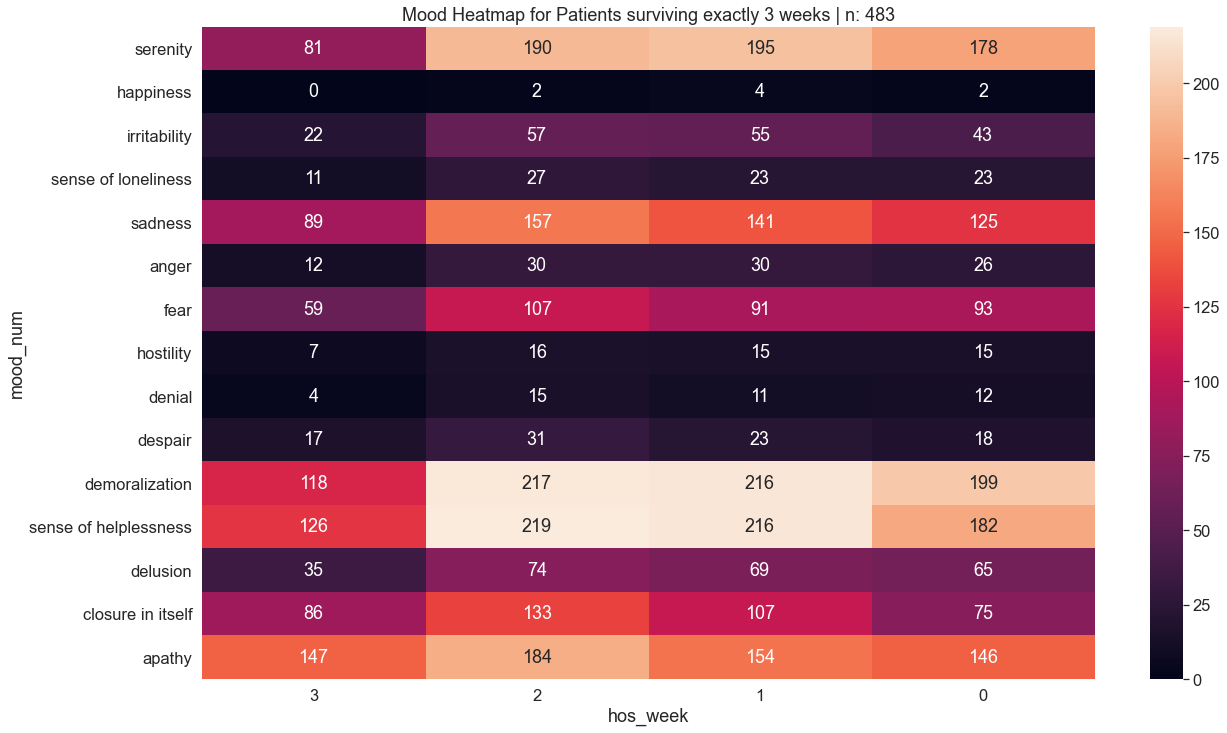

In [15]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 21]
df_ms = df_ms[df_ms['survival_time_days'] < 28]
df_ms = df_ms[df_ms['hos_week'] <= 3]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 3 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
# plt.savefig('./graphs/mood/mood_3w_exact.png', bbox_inches='tight')
plt.show()

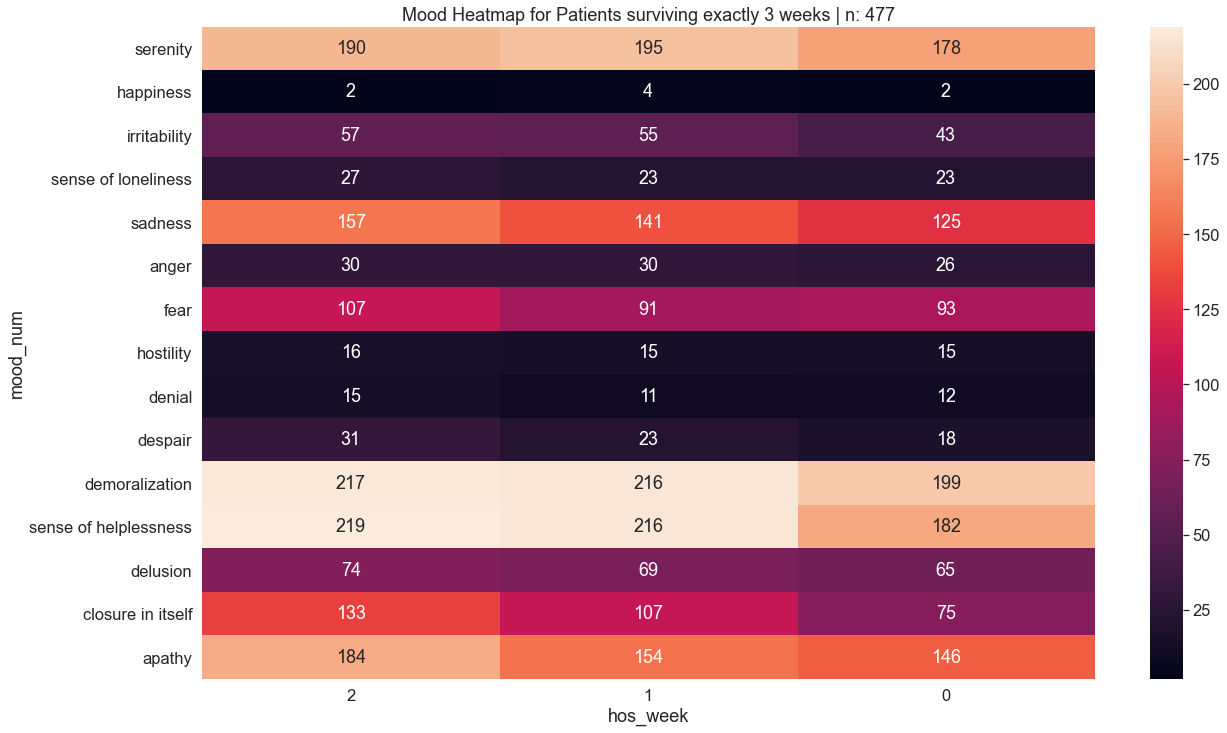

In [16]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 21]
df_ms = df_ms[df_ms['survival_time_days'] < 28]
df_ms = df_ms[df_ms['hos_week'] <= 2]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 3 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_3w_exact.png', bbox_inches='tight')
plt.show()

In [17]:
# diving into the data
dft = df_mw[df_mw['survival_time_days'] >= 21]
dft = dft[dft['survival_time_days'] < 28]
dft

IDEHR EHRType  survival_time_days                   Diagnosis  \
147      1423     EHR                26.0  Palliative (Non-Malignant)   
147      1423     EHR                26.0  Palliative (Non-Malignant)   
150      1423     EHR                26.0  Palliative (Non-Malignant)   
150      1423     EHR                26.0  Palliative (Non-Malignant)   
163      1423     EHR                26.0  Palliative (Non-Malignant)   
...       ...     ...                 ...                         ...   
101081  28906     AMB                26.0                      Breast   
101083  28906     AMB                26.0                      Breast   
101084  28906     AMB                26.0                      Breast   
101085  28906     AMB                26.0                      Breast   
101085  28906     AMB                26.0                      Breast   

                     mood_num  hos_week  
147                 happiness         0  
147                  serenity         0  
150                 happiness         1  
150                  serenity         1  
163                 happiness         2  
...                       ...       ...  
101081                 apathy         2  
101083                 apathy         3  
101084         demoralization         3  
101085      closure in itself         3  
101085  sense of helplessness         3  

[5052 rows x 6 columns]

In [18]:
dft.hos_week.value_counts()

2    1500
1    1373
0    1226
3     942
4       7
5       4
Name: hos_week, dtype: int64

In [19]:
len(dft[dft['hos_week'] >= 3].IDEHR.unique())

375

In [20]:
len(dft.IDEHR.unique())

483

In [21]:
df_ma[df_ma['IDEHR'] == 1442]

IDEHR EHRType        TimeStamp_Insert                     SOH  \
292   1442     EHR 2015-10-22 15:31:17.457 2015-10-16 18:03:45.160   
292   1442     EHR 2015-10-22 15:31:17.457 2015-10-16 18:03:45.160   
293   1442     EHR 2015-10-22 20:45:19.887 2015-10-16 18:03:45.160   
294   1442     EHR 2015-10-23 07:07:03.497 2015-10-16 18:03:45.160   
295   1442     EHR 2015-10-23 18:11:10.857 2015-10-16 18:03:45.160   
296   1442     EHR 2015-10-25 07:52:11.297 2015-10-16 18:03:45.160   
296   1442     EHR 2015-10-25 07:52:11.297 2015-10-16 18:03:45.160   
296   1442     EHR 2015-10-25 07:52:11.297 2015-10-16 18:03:45.160   
296   1442     EHR 2015-10-25 07:52:11.297 2015-10-16 18:03:45.160   
297   1442     EHR 2015-10-25 16:50:46.740 2015-10-16 18:03:45.160   
298   1442     EHR 2015-10-26 06:41:17.113 2015-10-16 18:03:45.160   
299   1442     EHR 2015-10-27 05:25:35.197 2015-10-16 18:03:45.160   
300   1442     EHR 2015-10-27 05:26:06.833 2015-10-16 18:03:45.160   
301   1442     EHR 2015-10-28 06:58:11.953 2015-10-16 18:03:45.160   
302   1442     EHR 2015-10-29 12:31:04.083 2015-10-16 18:03:45.160   
303   1442     EHR 2015-10-30 12:16:23.107 2015-10-16 18:03:45.160   
304   1442     EHR 2015-10-30 14:04:18.850 2015-10-16 18:03:45.160   
305   1442     EHR 2015-10-30 17:49:07.537 2015-10-16 18:03:45.160   
306   1442     EHR 2015-10-31 02:42:58.470 2015-10-16 18:03:45.160   
306   1442     EHR 2015-10-31 02:42:58.470 2015-10-16 18:03:45.160   
306   1442     EHR 2015-10-31 02:42:58.470 2015-10-16 18:03:45.160   
307   1442     EHR 2015-10-31 11:41:34.630 2015-10-16 18:03:45.160   
308   1442     EHR 2015-11-02 11:55:47.190 2015-10-16 18:03:45.160   
308   1442     EHR 2015-11-02 11:55:47.190 2015-10-16 18:03:45.160   
309   1442     EHR 2015-11-02 12:55:31.553 2015-10-16 18:03:45.160   
309   1442     EHR 2015-11-02 12:55:31.553 2015-10-16 18:03:45.160   
309   1442     EHR 2015-11-02 12:55:31.553 2015-10-16 18:03:45.160   
309   1442     EHR 2015-11-02 12:55:31.553 2015-10-16 18:03:45.160   
310   1442     EHR 2015-11-03 12:20:40.527 2015-10-16 18:03:45.160   
310   1442     EHR 2015-11-03 12:20:40.527 2015-10-16 18:03:45.160   
311   1442     EHR 2015-11-04 12:15:36.173 2015-10-16 18:03:45.160   
312   1442     EHR 2015-11-05 12:04:17.933 2015-10-16 18:03:45.160   
313   1442     EHR 2015-11-05 16:53:51.803 2015-10-16 18:03:45.160   
314   1442     EHR 2015-11-06 14:12:50.107 2015-10-16 18:03:45.160   
314   1442     EHR 2015-11-06 14:12:50.107 2015-10-16 18:03:45.160   
314   1442     EHR 2015-11-06 14:12:50.107 2015-10-16 18:03:45.160   
315   1442     EHR 2015-11-07 02:29:10.687 2015-10-16 18:03:45.160   
315   1442     EHR 2015-11-07 02:29:10.687 2015-10-16 18:03:45.160   
315   1442     EHR 2015-11-07 02:29:10.687 2015-10-16 18:03:45.160   
315   1442     EHR 2015-11-07 02:29:10.687 2015-10-16 18:03:45.160   
316   1442     EHR 2015-11-07 13:55:28.930 2015-10-16 18:03:45.160   
316   1442     EHR 2015-11-07 13:55:28.930 2015-10-16 18:03:45.160   
316   1442     EHR 2015-11-07 13:55:28.930 2015-10-16 18:03:45.160   
317   1442     EHR 2015-11-08 12:55:42.483 2015-10-16 18:03:45.160   
317   1442     EHR 2015-11-08 12:55:42.483 2015-10-16 18:03:45.160   
317   1442     EHR 2015-11-08 12:55:42.483 2015-10-16 18:03:45.160   
318   1442     EHR 2015-11-08 16:01:25.920 2015-10-16 18:03:45.160   
318   1442     EHR 2015-11-08 16:01:25.920 2015-10-16 18:03:45.160   
318   1442     EHR 2015-11-08 16:01:25.920 2015-10-16 18:03:45.160   
319   1442     EHR 2015-11-08 21:15:18.977 2015-10-16 18:03:45.160   
319   1442     EHR 2015-11-08 21:15:18.977 2015-10-16 18:03:45.160   
319   1442     EHR 2015-11-08 21:15:18.977 2015-10-16 18:03:45.160   
320   1442     EHR 2015-11-09 15:09:24.303 2015-10-16 18:03:45.160   
321   1442     EHR 2015-11-09 16:21:37.593 2015-10-16 18:03:45.160   
321   1442     EHR 2015-11-09 16:21:37.593 2015-10-16 18:03:45.160   
321   1442     EHR 2015-11-09 16:21:37.593 2015-10-16 18:03:45.160   
322   1442     

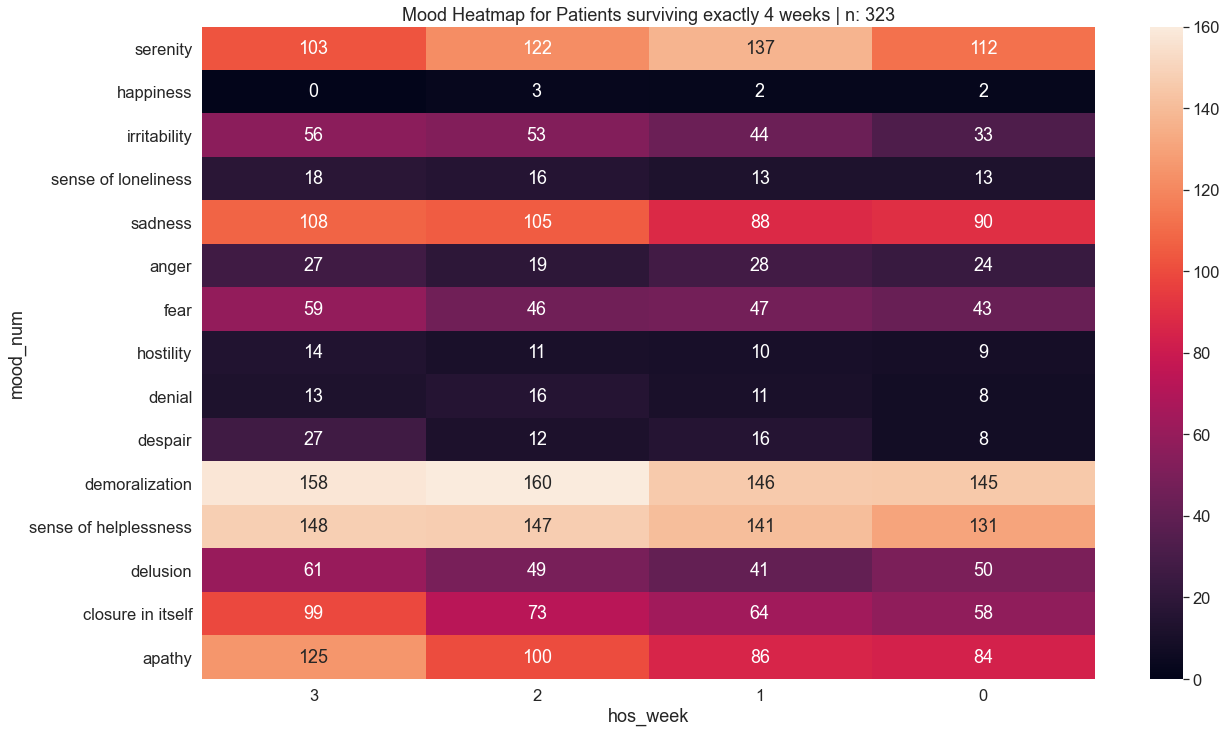

In [22]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 28]
df_ms = df_ms[df_ms['survival_time_days'] < 35]
df_ms = df_ms[df_ms['hos_week'] <= 3]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 4 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_4w_exact.png', bbox_inches='tight')
plt.show()

In [23]:
dft = df_mw[df_mw['survival_time_days'] >= 28]
dft = dft[dft['survival_time_days'] < 35]
dft.hos_week.value_counts()

3     1045
2      948
1      886
0      821
4      650
5        4
11       2
10       2
9        2
8        2
7        1
6        1
Name: hos_week, dtype: int64

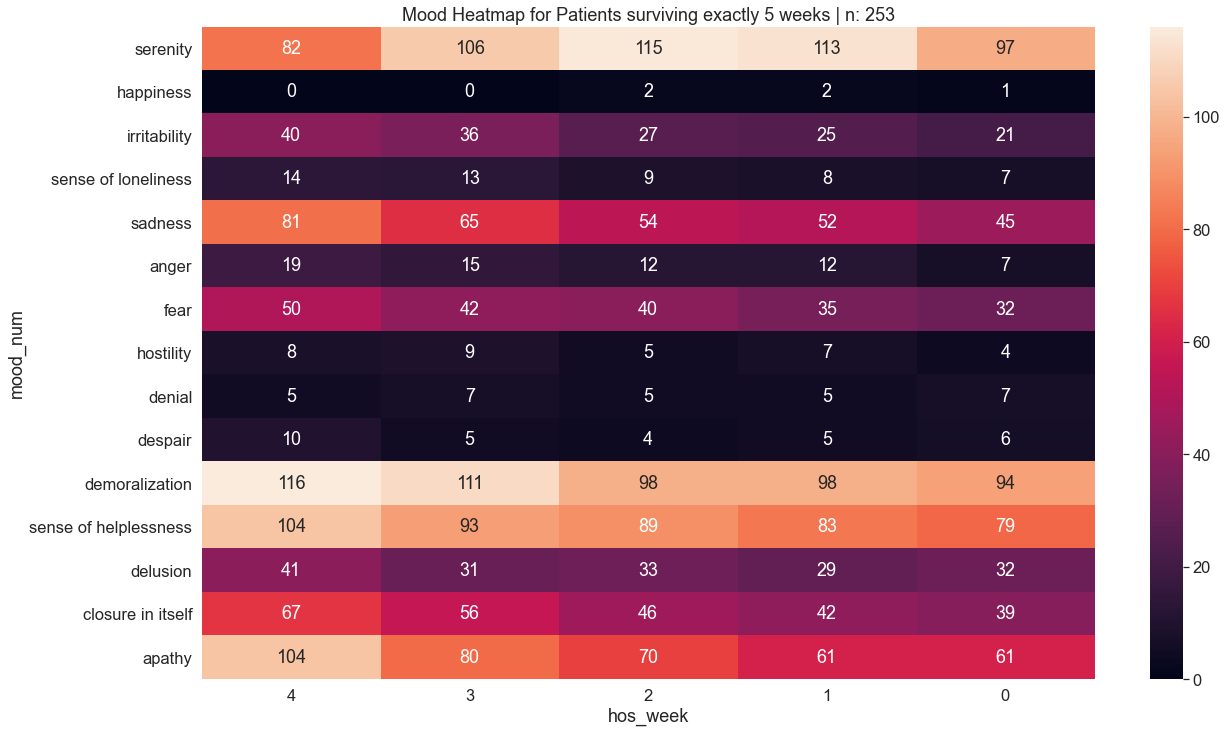

In [24]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 35]
df_ms = df_ms[df_ms['survival_time_days'] < 42]
df_ms = df_ms[df_ms['hos_week'] <= 4]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 5 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_5w_exact.png', bbox_inches='tight')
plt.show()

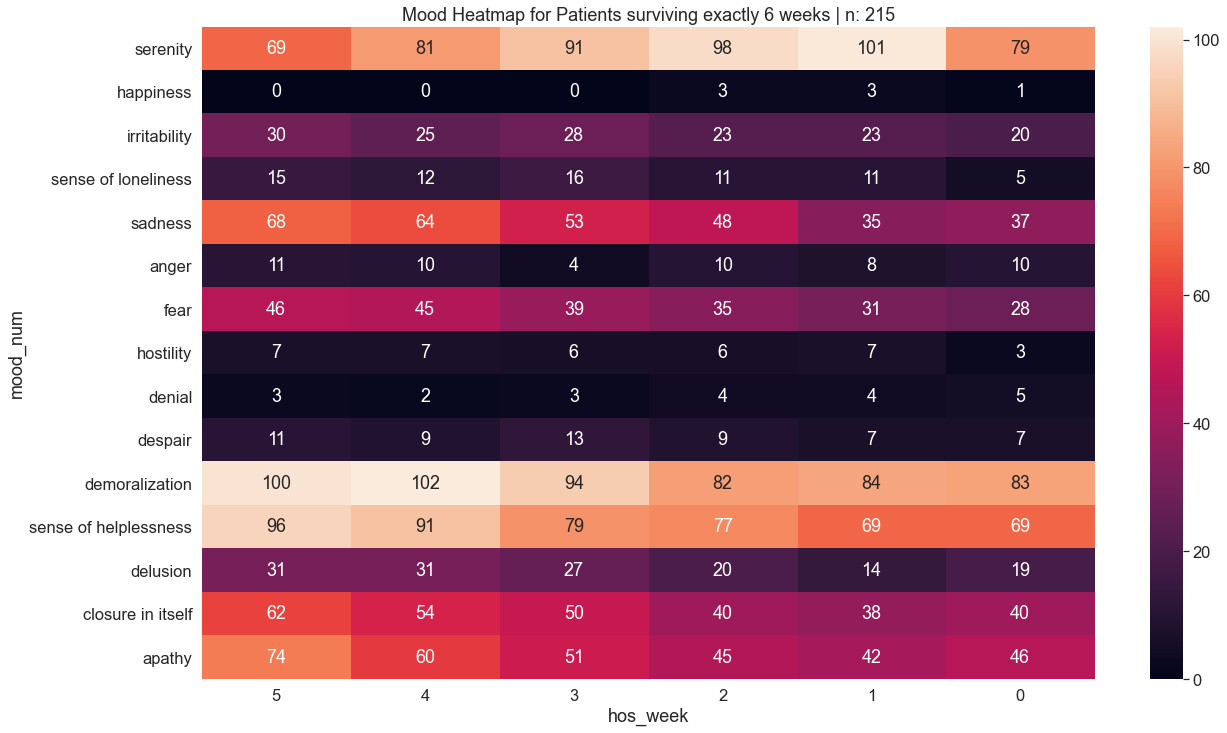

In [25]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 42]
df_ms = df_ms[df_ms['survival_time_days'] < 49]
df_ms = df_ms[df_ms['hos_week'] <= 5]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 6 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_6w_exact.png', bbox_inches='tight')
plt.show()

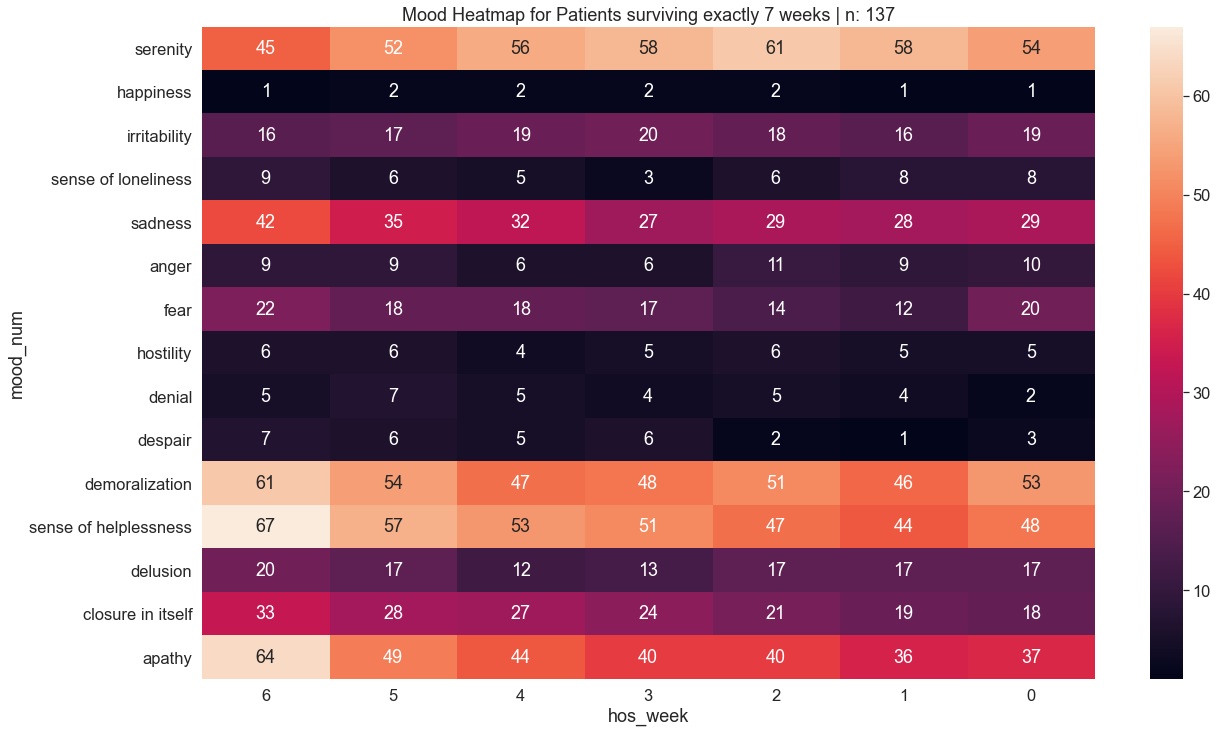

In [26]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 49]
df_ms = df_ms[df_ms['survival_time_days'] < 56]
df_ms = df_ms[df_ms['hos_week'] <= 6]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 7 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_7w_exact.png', bbox_inches='tight')
plt.show()

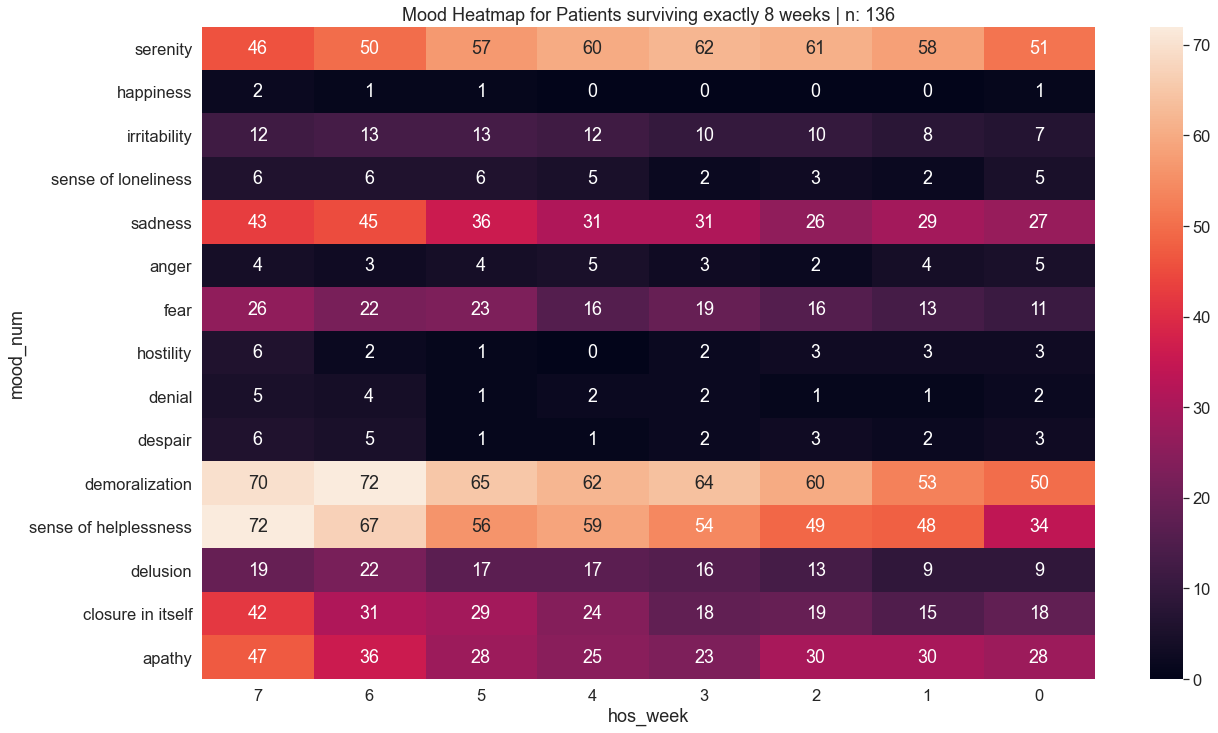

In [27]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 56]
df_ms = df_ms[df_ms['survival_time_days'] < 63]
df_ms = df_ms[df_ms['hos_week'] <= 7]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 8 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_8w_exact.png', bbox_inches='tight')
plt.show()

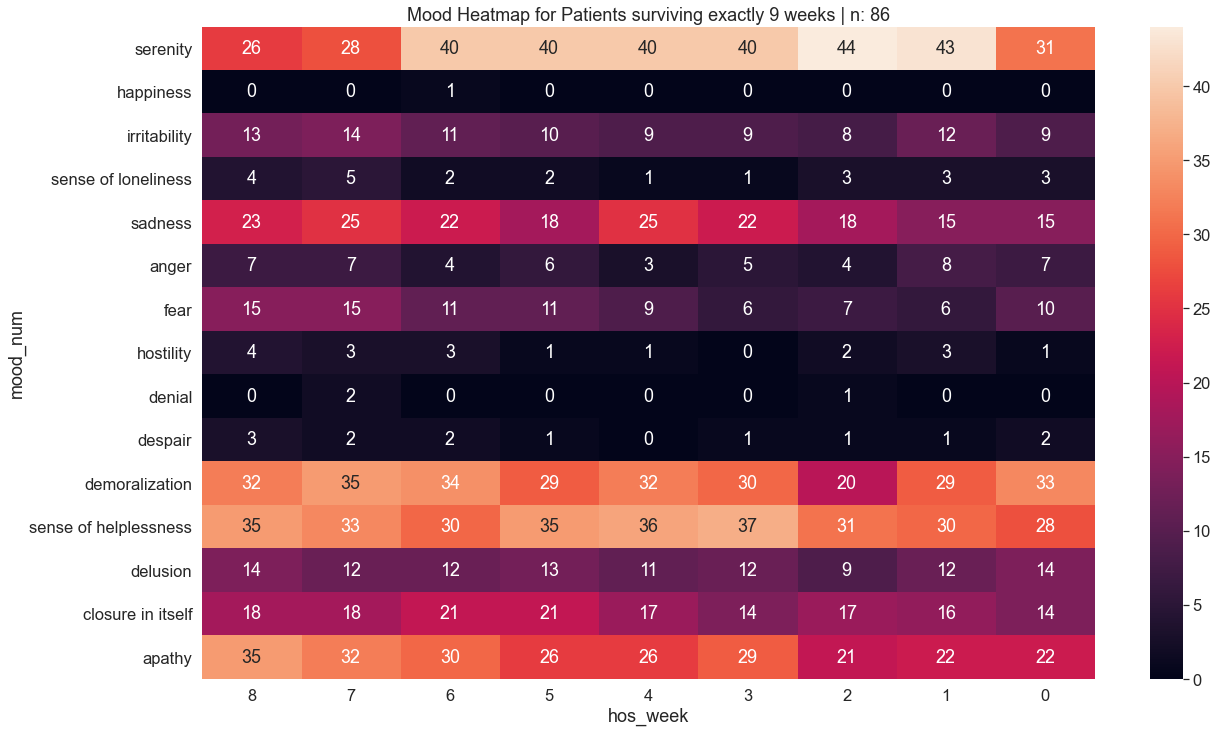

In [28]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['survival_time_days'] < 70]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 9 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_9w_exact.png', bbox_inches='tight')
plt.show()

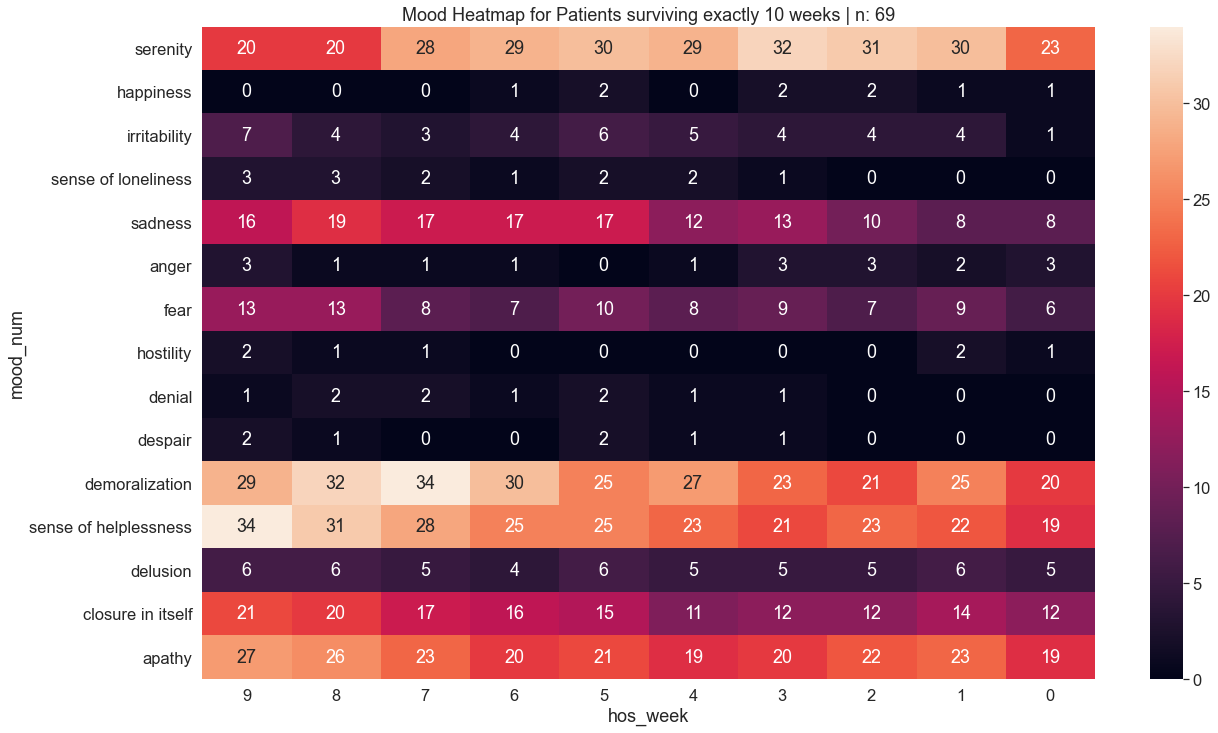

In [29]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 70]
df_ms = df_ms[df_ms['survival_time_days'] < 77]
df_ms = df_ms[df_ms['hos_week'] <= 9]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 10 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_10w_exact.png', bbox_inches='tight')
plt.show()

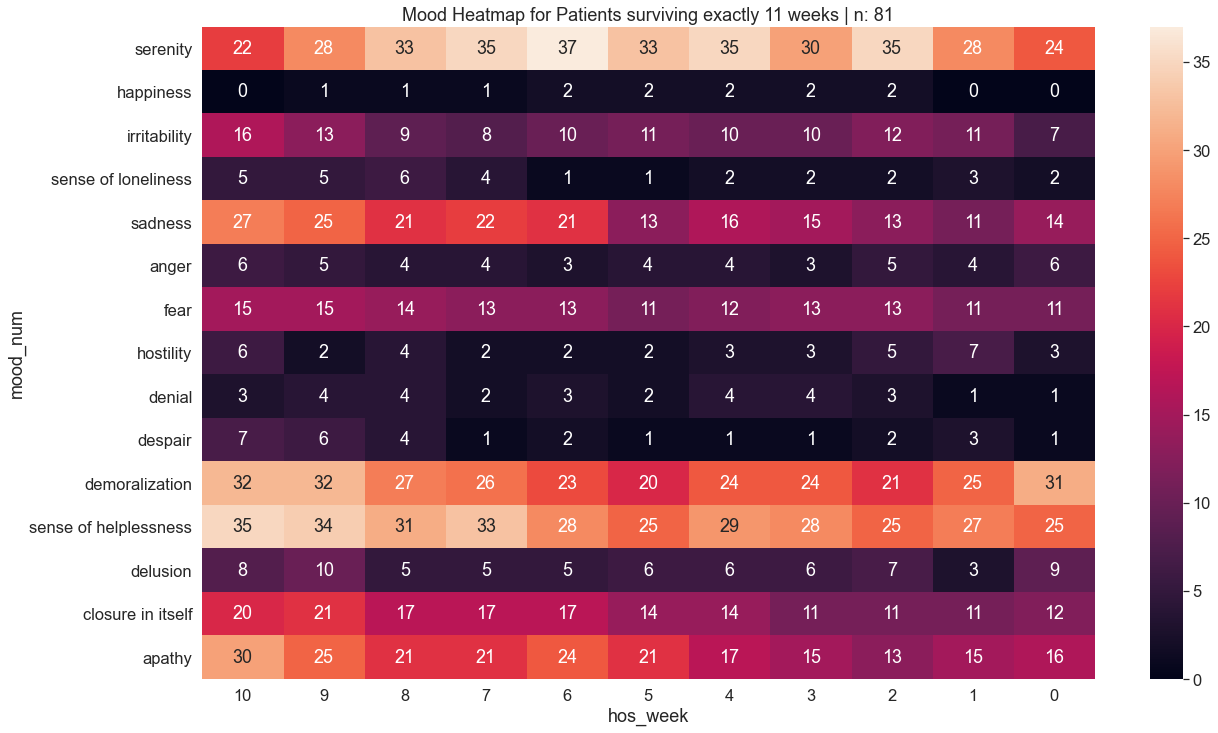

In [30]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 77]
df_ms = df_ms[df_ms['survival_time_days'] < 84]
df_ms = df_ms[df_ms['hos_week'] <= 10]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 11 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_11w_exact.png', bbox_inches='tight')
plt.show()

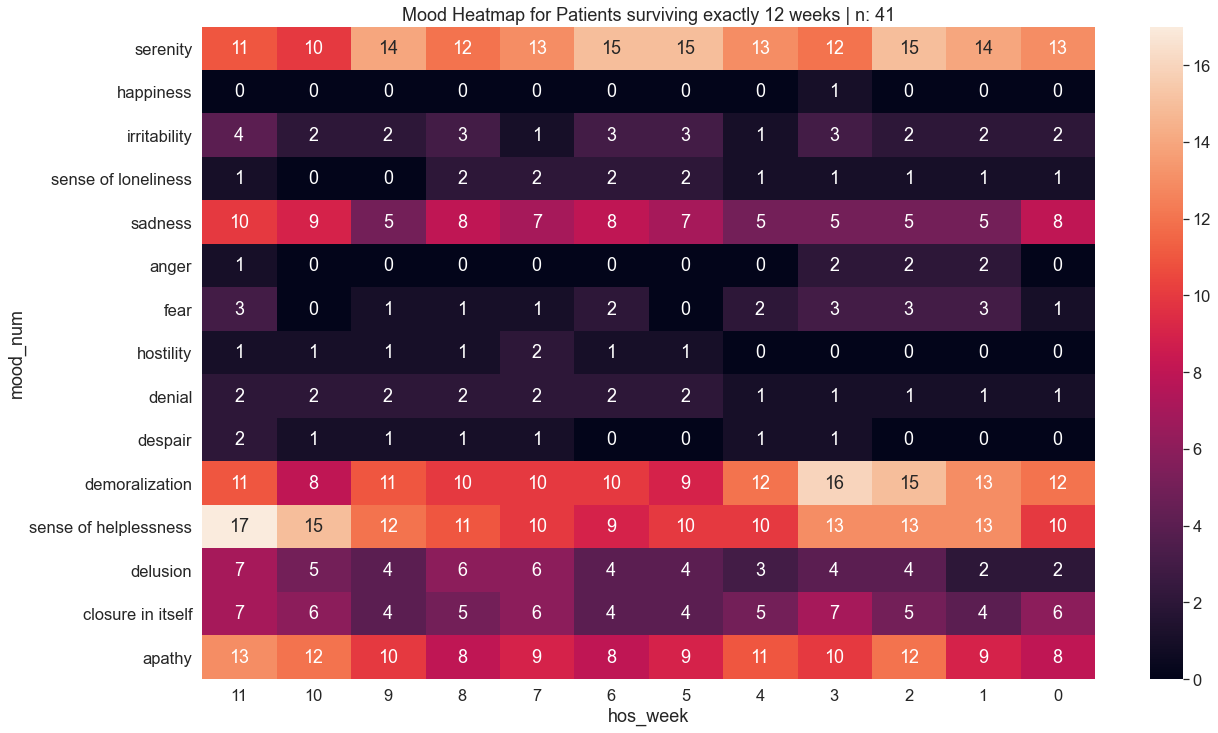

In [31]:
# heatmaps going backward from the death day for patients surviving exactly x weeks
df_ms = df_mw[df_mw['survival_time_days'] >= 84]
df_ms = df_ms[df_ms['survival_time_days'] < 91]
df_ms = df_ms[df_ms['hos_week'] <= 11]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 12 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_12w_exact.png', bbox_inches='tight')
plt.show()

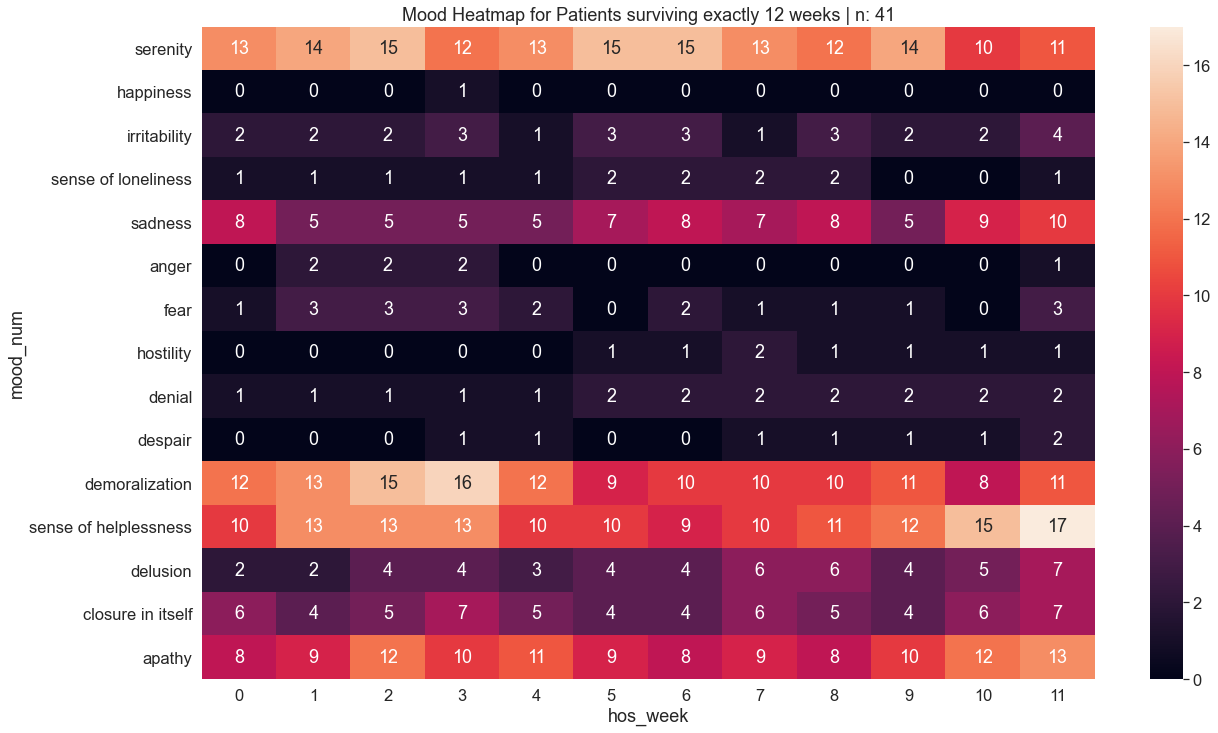

In [32]:
# TESTING by not inverting x-axis
df_ms = df_mw[df_mw['survival_time_days'] >= 84]
df_ms = df_ms[df_ms['survival_time_days'] < 91]
df_ms = df_ms[df_ms['hos_week'] <= 11]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
# ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for Patients surviving exactly 12 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
# plt.savefig('./graphs/mood/mood_12w_exact.png', bbox_inches='tight')
plt.show()

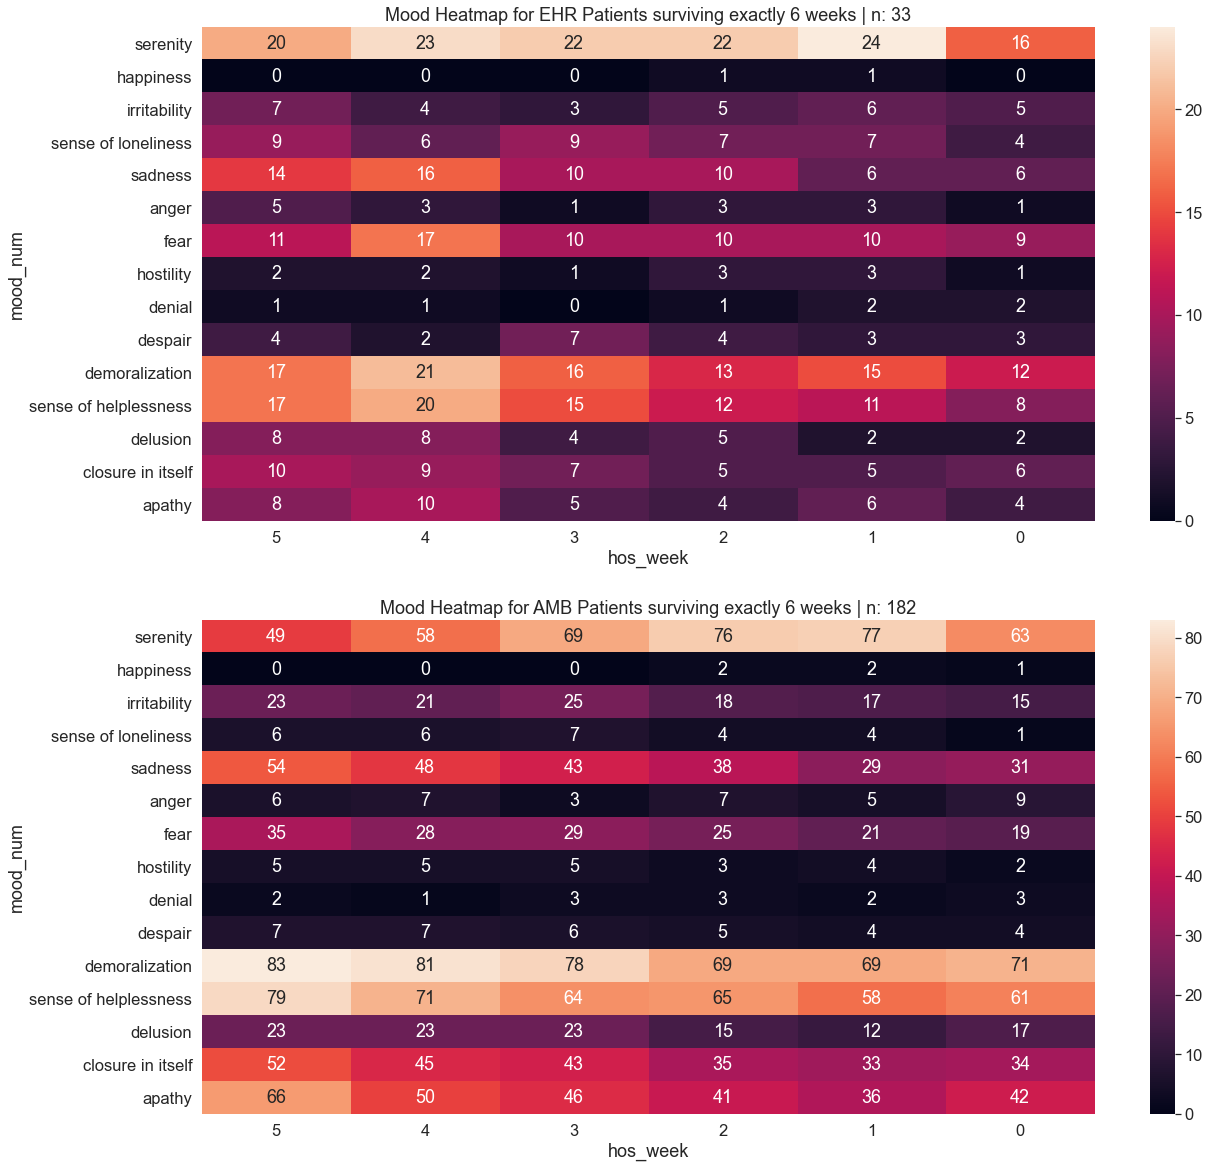

In [35]:
# heatmaps for patients surviving exactly x weeks split by EHRType
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 42]
df_ms = df_ms[df_ms['survival_time_days'] < 49]
df_ms = df_ms[df_ms['hos_week'] <= 5]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
cats1 = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats1.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats1, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving exactly 6 weeks | n: ' + str(n1))
ax1.invert_xaxis()
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving exactly 6 weeks | n: ' + str(n2))
ax2.invert_xaxis()
plt.savefig('./graphs/mood/mood_ehr_6w_exact.png', bbox_inches='tight')
plt.show()

In [37]:
df_ms = df_mw[df_mw['survival_time_days'] >= 42]
df_ms = df_ms[df_ms['survival_time_days'] < 49]
df_ms.hos_week.value_counts()

5    638
4    605
3    565
2    519
1    483
0    459
6    430
8      3
7      2
Name: hos_week, dtype: int64

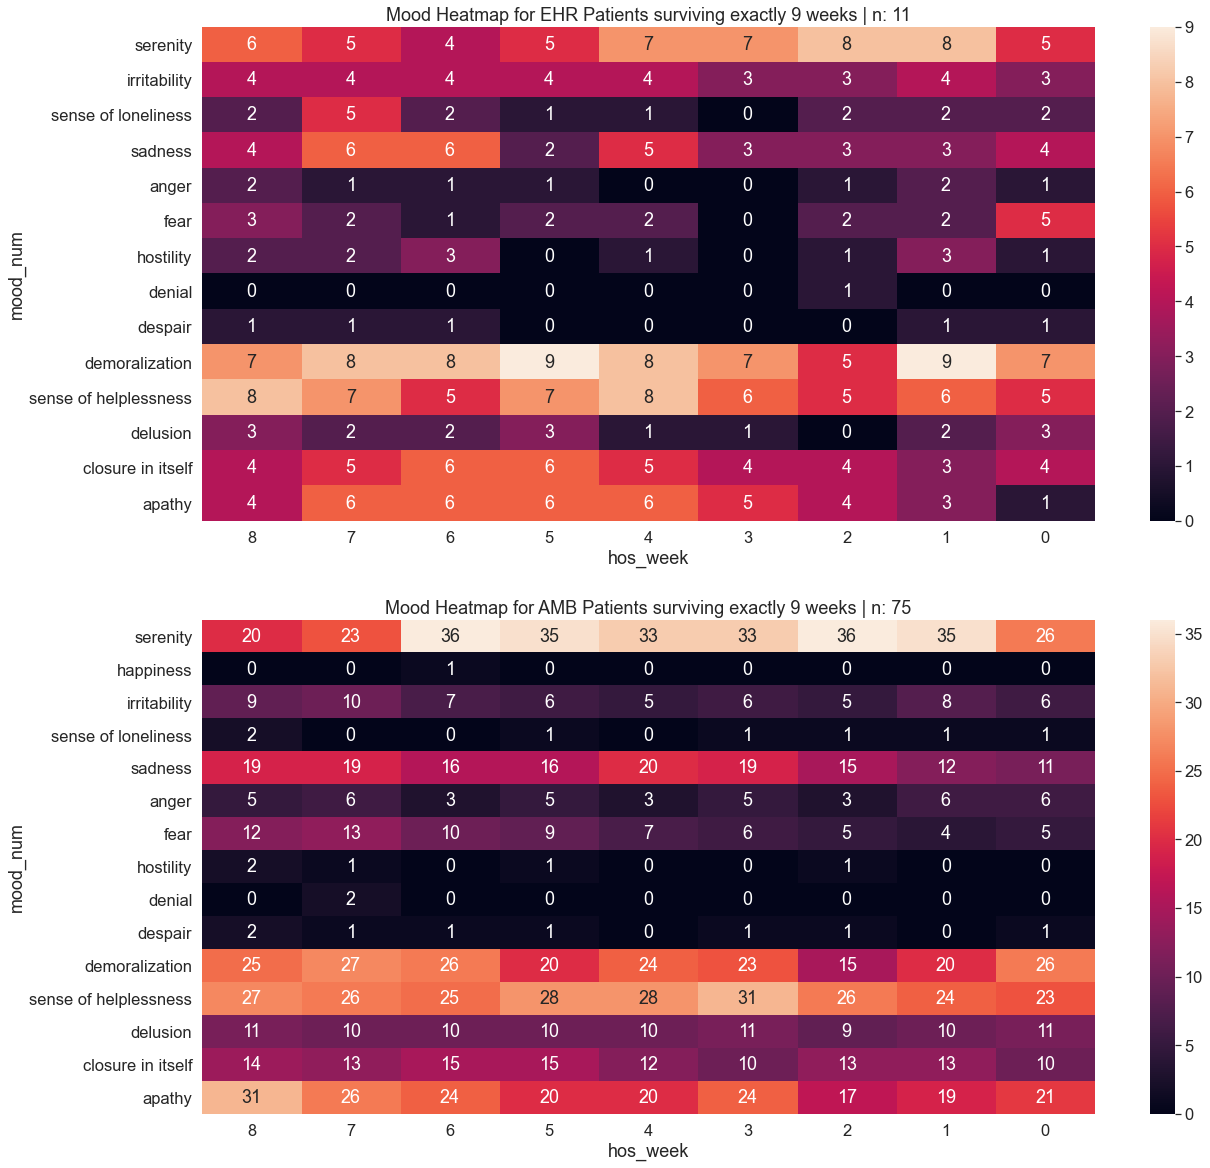

In [34]:
# heatmaps for patients surviving exactly x weeks split by EHRType
plt.rcParams['figure.figsize'] = [20, 20]
fig, (ax1, ax2) = plt.subplots(2, 1)
df_ms = df_mw[df_mw['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['survival_time_days'] < 70]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df1 = df_ms[df_ms['EHRType'] == 'EHR']
df2 = df_ms[df_ms['EHRType'] == 'AMB']
n1 = len(df1.IDEHR.unique())
n2 = len(df2.IDEHR.unique())
df1 = df1[['mood_num', 'hos_week']].reset_index(drop=True)
df1 = df1.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
df2 = df2[['mood_num', 'hos_week']].reset_index(drop=True)
df2 = df2.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
cats1 = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats1.reverse()
df1['mood_num'] = pd.Categorical(df1['mood_num'], categories=cats1, ordered=True)
df2['mood_num'] = pd.Categorical(df2['mood_num'], categories=cats, ordered=True)
df1 = df1.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
df2 = df2.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
sns.heatmap(df1, annot=True, fmt='g', ax=ax1)
ax1.set_facecolor('xkcd:black')
ax1.set_title('Mood Heatmap for EHR Patients surviving exactly 9 weeks | n: ' + str(n1))
ax1.invert_xaxis()
sns.heatmap(df2, annot=True, fmt='g', ax=ax2)
ax2.set_facecolor('xkcd:black')
ax2.set_title('Mood Heatmap for AMB Patients surviving exactly 9 weeks | n: ' + str(n2))
ax2.invert_xaxis()
plt.savefig('./graphs/mood/mood_ehr_9w_exact.png', bbox_inches='tight')
plt.show()

In [44]:
# heatmaps split by setting
df_set = pd.read_excel('./vidas_data/IDEHR-EHRType-OU.xlsx')
df_set = df_set.rename(columns={"UO (Setting)\n": 'Setting'})
df_set

PatientID  IDEHR EHRType             Setting
0              1      1     AMB         Valutazione
1              2      3     AMB         Valutazione
2              1      4     AMB          DayHospice
3              2      5     AMB          DayHospice
4              3      7     AMB         Valutazione
...          ...    ...     ...                 ...
22922      60826   5428     EHR             Hospice
22923      60834   5429     EHR             Hospice
22924      60652   5430     EHR             Hospice
22925      60836   5431     EHR             Hospice
22926      60836   5432     EHR  Hospice Pediatrico

[22927 rows x 4 columns]

In [45]:
# merge with df_mw
df_st = pd.merge(df_mw, df_set, on=['IDEHR', 'EHRType'])
df_st

IDEHR EHRType  survival_time_days                   Diagnosis  \
0       1382     EHR                45.0  Palliative (Non-Malignant)   
1       1382     EHR                45.0  Palliative (Non-Malignant)   
2       1382     EHR                45.0  Palliative (Non-Malignant)   
3       1382     EHR                45.0  Palliative (Non-Malignant)   
4       1382     EHR                45.0  Palliative (Non-Malignant)   
...      ...     ...                 ...                         ...   
65614  29399     AMB                 5.0                        Lung   
65615  29411     AMB                 1.0                        Lung   
65616  29411     AMB                 1.0                        Lung   
65617  29440     AMB                 2.0                        Lung   
65618  29440     AMB                 2.0                        Lung   

                    mood_num  hos_week  PatientID    Setting  
0          closure in itself         3      30759    Hospice  
1                   serenity         3      30759    Hospice  
2                   serenity         4      30759    Hospice  
3          closure in itself         4      30759    Hospice  
4                     apathy         4      30759    Hospice  
...                      ...       ...        ...        ...  
65614  sense of helplessness         0      59878  Domicilio  
65615                   fear         0      59898  Domicilio  
65616                  anger         0      59898  Domicilio  
65617      closure in itself         0      59909  Domicilio  
65618         demoralization         0      59909  Domicilio  

[65619 rows x 8 columns]

In [48]:
df_st[['survival_time_days', 'Setting']].groupby(by='Setting').mean()

survival_time_days
Setting                                 
Domicilio                     136.326501
Domicilio Pediatrico          122.381443
Hospice                        31.406769
Hospice Pediatrico             18.931034

In [55]:
df_st[['Setting', 'IDEHR', 'EHRType']].drop_duplicates().Setting.value_counts()

Domicilio               3433
Hospice                 1708
Domicilio Pediatrico       7
Hospice Pediatrico         6
Name: Setting, dtype: int64

In [50]:
plt.rcParams['figure.figsize'] = [20, 12]
matplotlib.rcParams.update({'font.size': 15})
sns.set(font_scale=1.5)

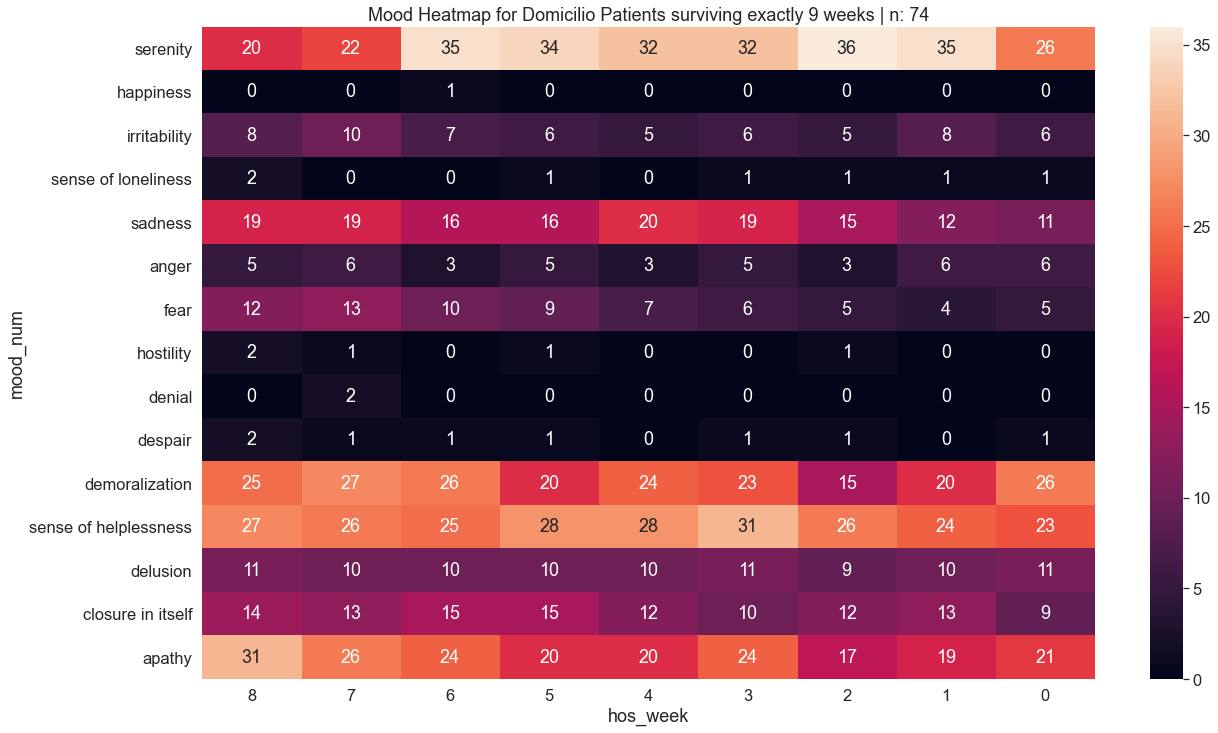

In [51]:
# heatmap for Domicilio for patients surviving exactly 9 weeks
setting = 'Domicilio'
df_ms = df_st[df_st['Setting'] == setting]
df_ms = df_ms[df_ms['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['survival_time_days'] < 70]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for ' + setting + ' Patients surviving exactly 9 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_' + setting + '_9w_exact.png', bbox_inches='tight')
plt.show()

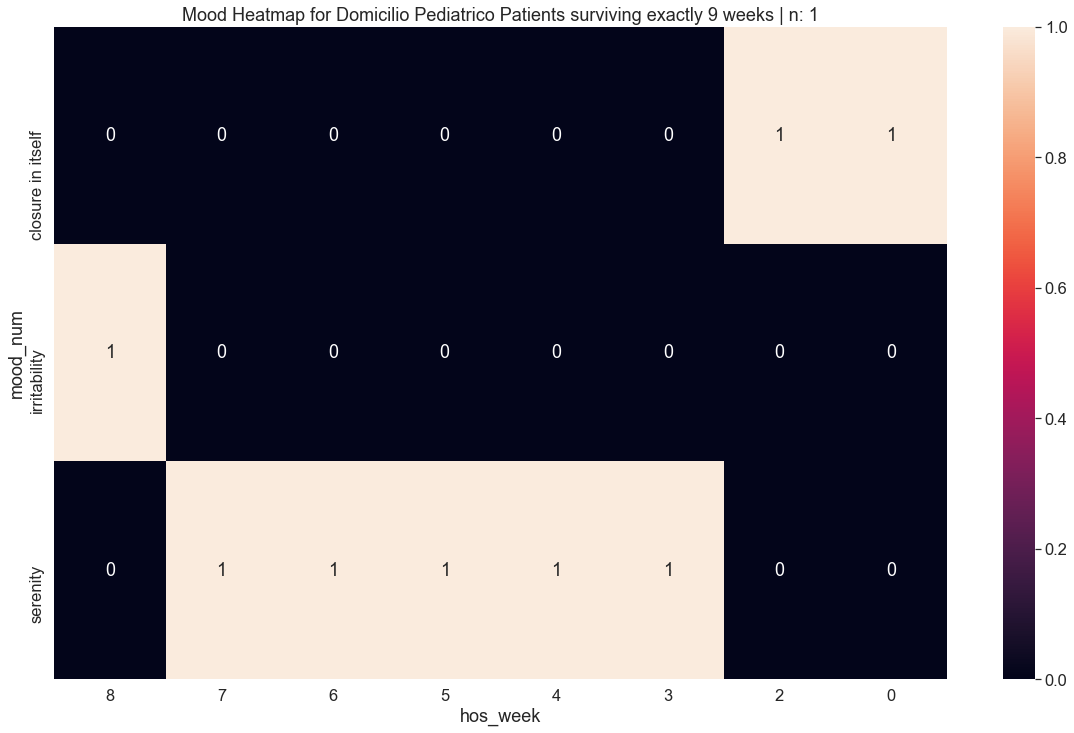

In [54]:
# heatmap for Domicilio for patients surviving exactly 9 weeks
setting = 'Domicilio Pediatrico'
df_ms = df_st[df_st['Setting'] == setting]
df_ms = df_ms[df_ms['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['survival_time_days'] < 70]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'happiness', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for ' + setting + ' Patients surviving exactly 9 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_' + setting + '_9w_exact.png', bbox_inches='tight')
plt.show()

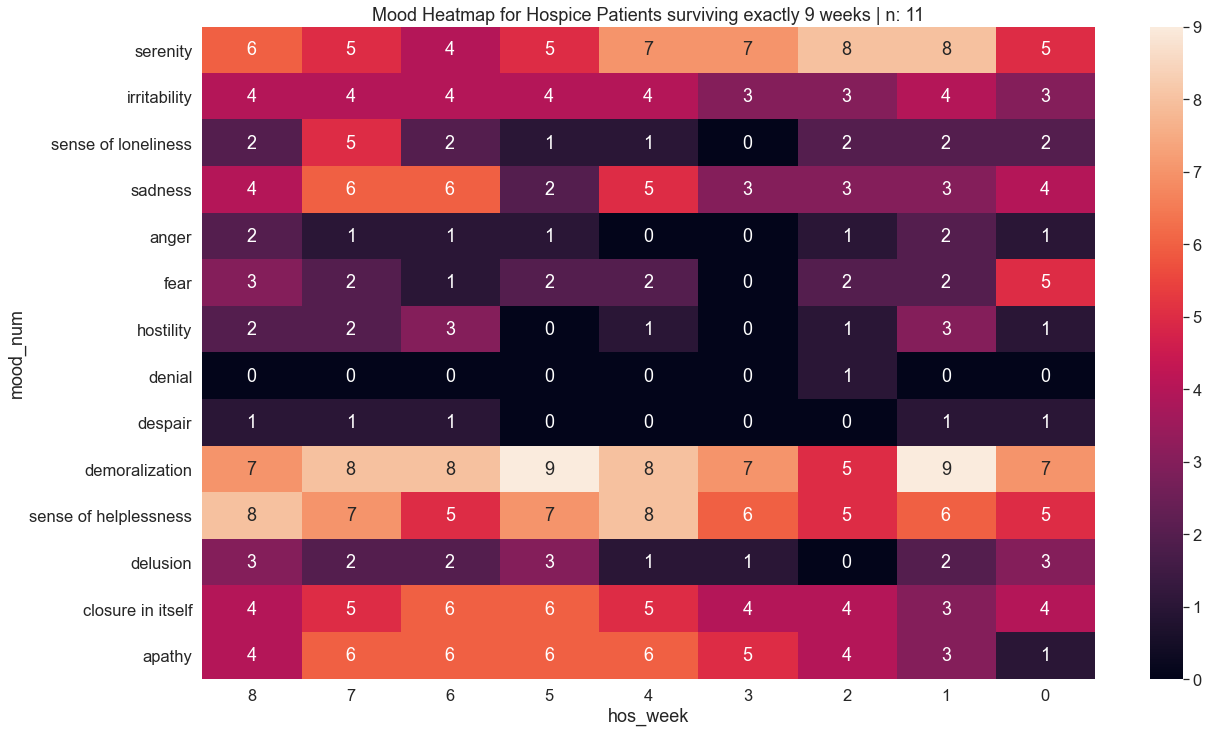

In [53]:
# heatmap for Hospice for patients surviving exactly 9 weeks
setting = 'Hospice'
df_ms = df_st[df_st['Setting'] == setting]
df_ms = df_ms[df_ms['survival_time_days'] >= 63]
df_ms = df_ms[df_ms['survival_time_days'] < 70]
df_ms = df_ms[df_ms['hos_week'] <= 8]
df_hm = df_ms[['mood_num', 'hos_week']].reset_index(drop=True)
df_hm = df_hm.groupby(['mood_num', 'hos_week']).size().to_frame('size').reset_index()
cats = ['apathy', 'closure in itself', 'delusion', 'sense of helplessness', 'demoralization', 'despair', 'denial', 'hostility', 'fear', 'anger', 'sadness', 'sense of loneliness', 'irritability', 'serenity']
cats.reverse()
df_hm['mood_num'] = pd.Categorical(df_hm['mood_num'], categories=cats, ordered=True)
df_hm = df_hm.pivot(index='mood_num', columns='hos_week', values='size').fillna(0)
ax = plt.axes()
sns.heatmap(df_hm, annot=True, fmt='g', ax=ax)
ax.invert_xaxis()
ax.set_facecolor('xkcd:black')
ax.set_title('Mood Heatmap for ' + setting + ' Patients surviving exactly 9 weeks | n: ' + str(len(df_ms.IDEHR.unique())))
plt.savefig('./graphs/mood/mood_' + setting + '_9w_exact.png', bbox_inches='tight')
plt.show()